# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net
### Preprocessing

#### **Vorbereitung**

In [8]:
# import libraries
import numpy as np
from uuid import uuid4
from random import randint
import os
from pandas import DataFrame
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)
    
import src.preprocessing as pre
import src.data_loader as dl
import src.visualization as vis
import src.model_constructor as mc

In [9]:
# boolean values to control the program flow
TESTING: bool = False
DOWNLOAD: bool = False

# setup a single index for control of preprocessing steps
CONTROL_INDEX: int = 4

In [10]:
# generate a unique identifier for this run
UUID: str = str(uuid4())

In [11]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

In [12]:
if DOWNLOAD:
    
    # download full dataset from kaggle
    dl.fetch_kaggle_dataset(dl.DATASET_ADDRESS)

In [13]:
if not TESTING:
    
    # load data from folder and split in training and evaluation data
    data_path = Path().cwd() / "data" / "raw"
    development_data, evaluation_data = dl.load_all_datasets(data_path)
    all_datasets = development_data + evaluation_data

else:

    # program testing set
    test = dl.load_dataset(Path("./data/raw/1D.csv"))

READING DEVELOPMENT DATA
0D.csv successfully loaded.
1D.csv successfully loaded.


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\0D.csv


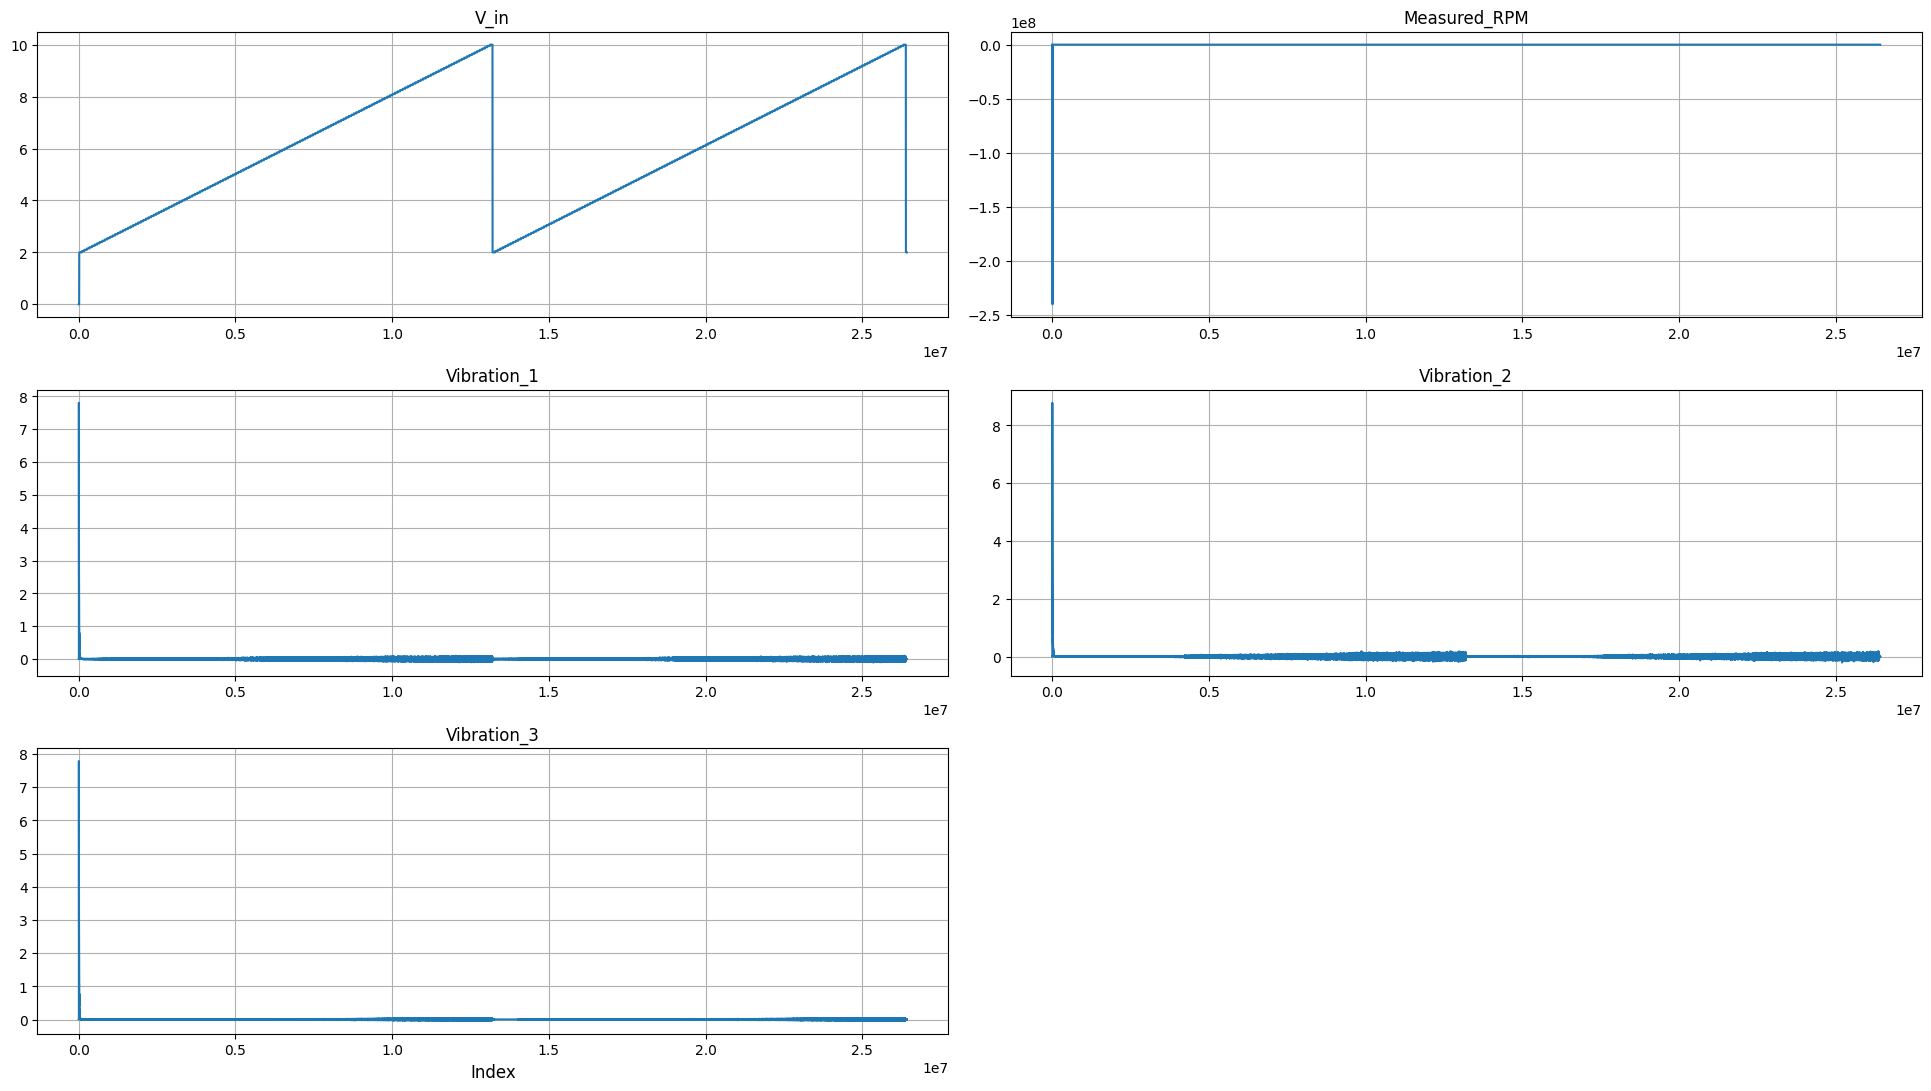

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\1D.csv


KeyboardInterrupt: 

In [ ]:
if not TESTING:
    for index, dataset in enumerate(all_datasets):
        # visualize one random dataset for data validation
        print(dataset.attrs["path"])
        vis.plot_columns_as_subplots(dataset, dataset.columns)

else:

    # visualize the program testing set
    vis.plot_columns_as_subplots(test, test.columns)

#### **Preprocessing**

##### **Bereinigung der Daten**
Jeder Datensatz beginnt mit negativen Spitzen in den V_in und den Measured_RPM. Tresholding einer der beiden Messreihen entfernt diese Fehler im jeweiligen Datensatz. Durch Anpassung der Indizes beginnt jeder Datensatz mit Index 0.



# ACHTUNG
- Split in zwei Anläufe fehlt!
- RobustScaler Daten kontrollieren. Die Werte sollen in einer Range +-1 liegen!

In [ ]:
if not TESTING:

    measurement_cycles = []

    for index, dataset in enumerate(all_datasets):
        pre.apply_threshold(dataset, threshold=0, column="V_in", mode="le", reset_index=False)
        dataset = pre.discard_data(dataset, end=50_000, reset_index=True)
        subsets = pre.split_by_gradient_direction(dataset, column="V_in", reset_index=True)
        for subset in subsets:
            measurement_cycles.append(subset)
        
else:
    
    pre.apply_threshold(test, threshold=0, column="V_in", mode="le", reset_index=False)
    test = pre.discard_data(test, end=50_000, reset_index=True)
    test_measurement_cycles = pre.split_by_gradient_direction(test, column="V_in")

12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.
12288 rows discarded.
Limits interpreted as integers.
37712 rows discarded.


c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\0D_0.csv


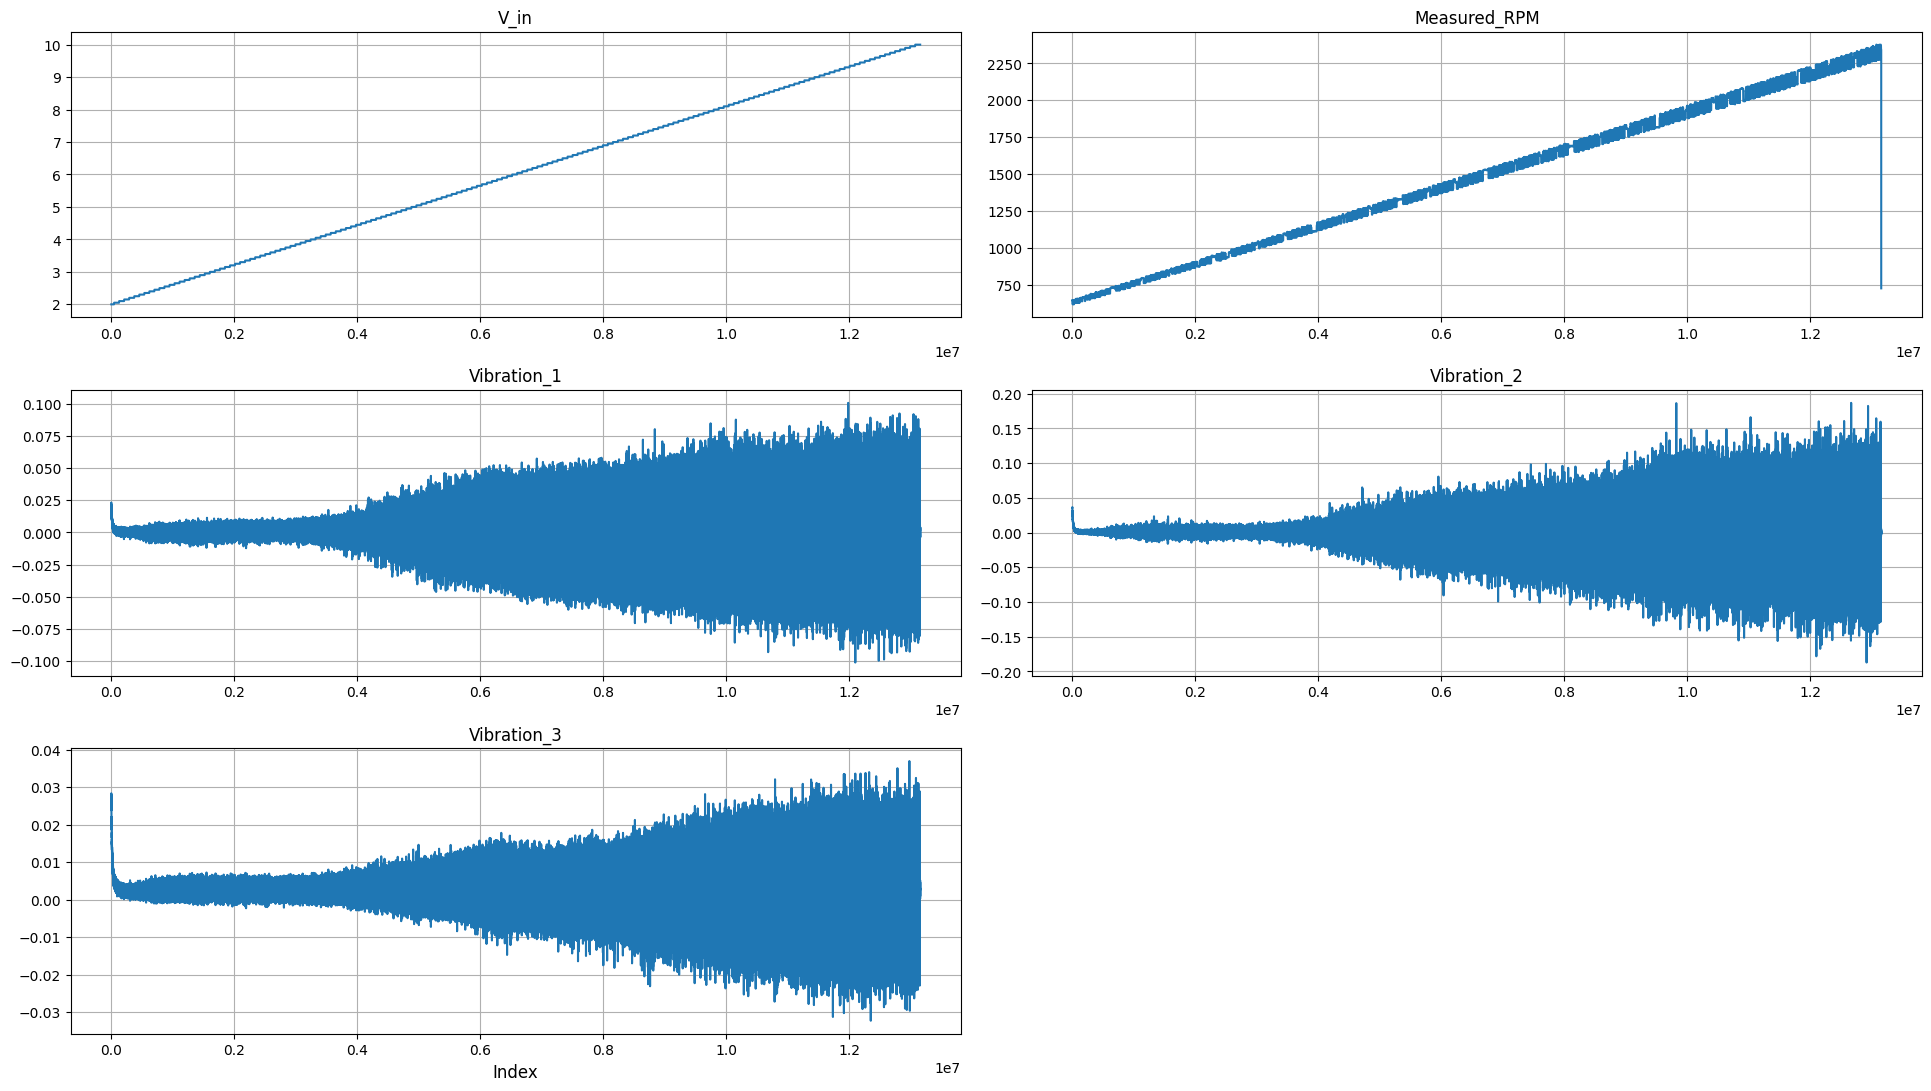

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\0D_1.csv


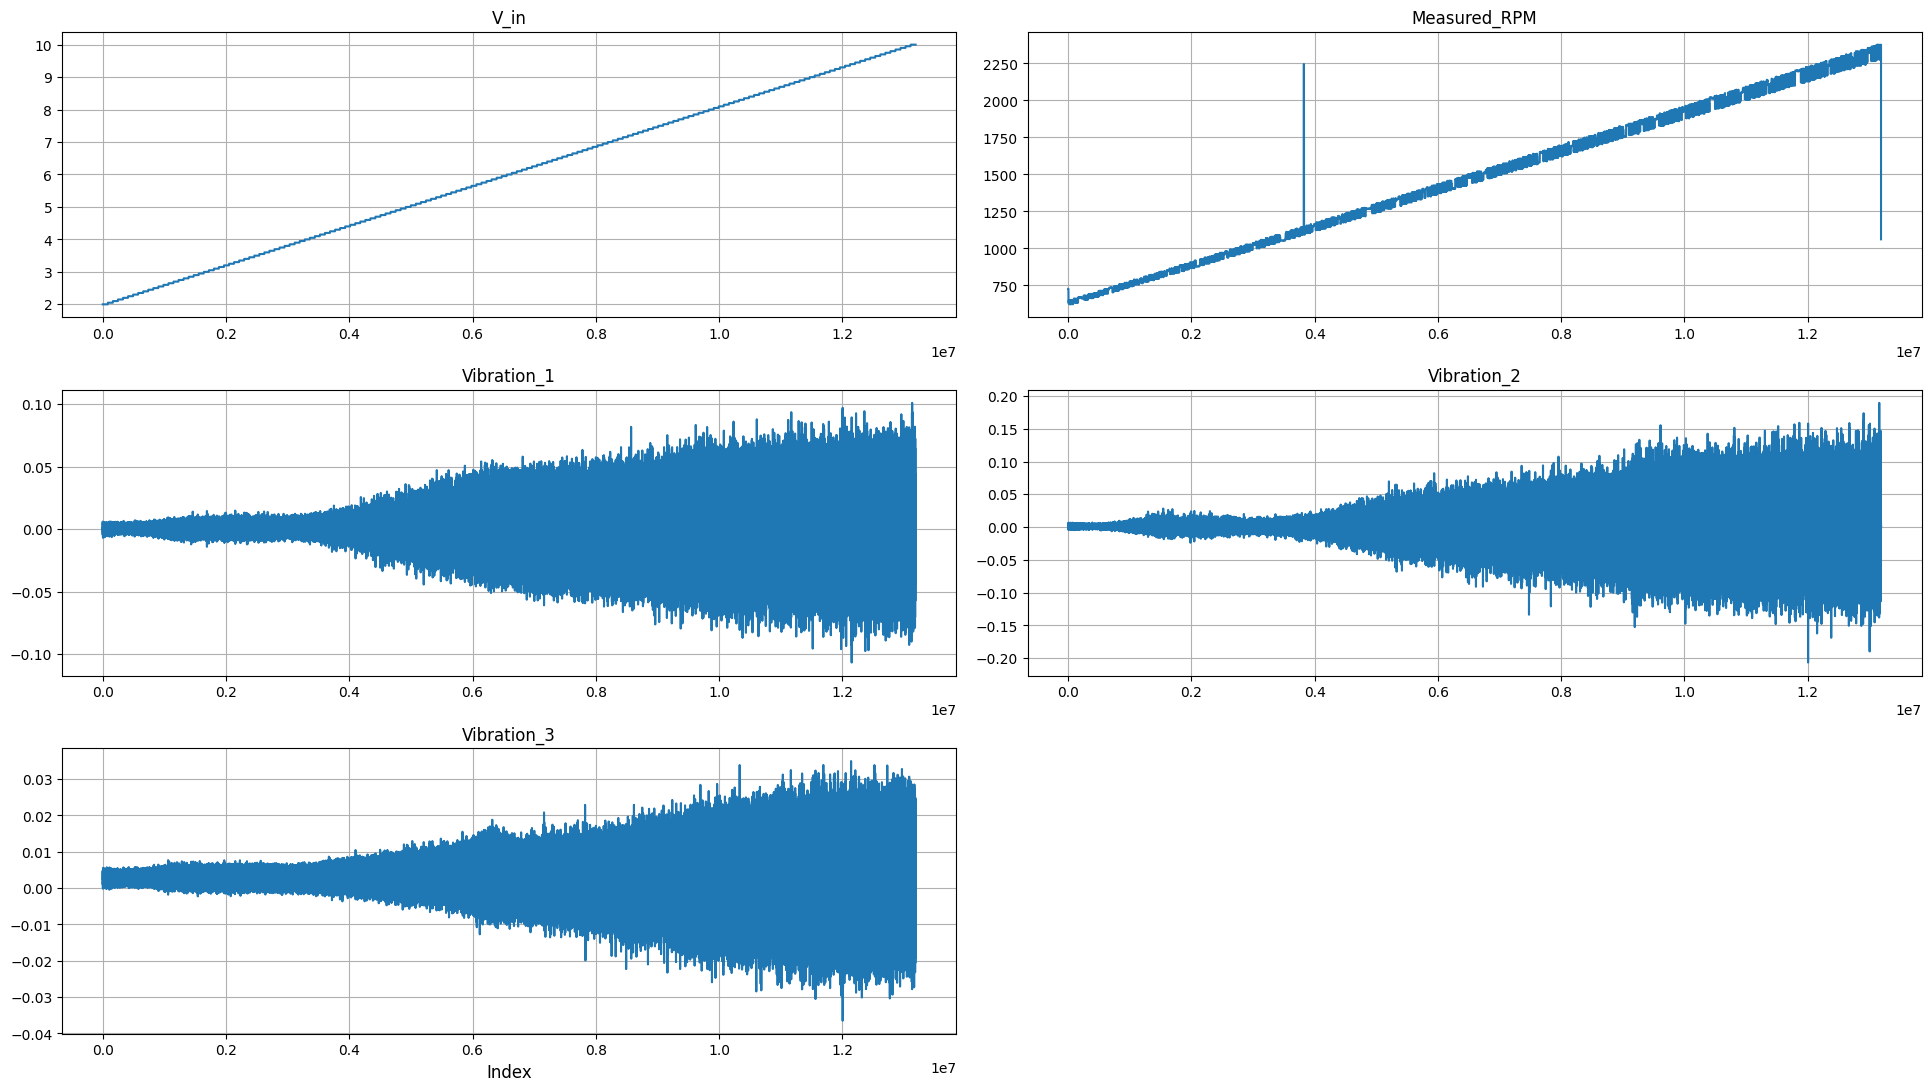

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\1D_0.csv


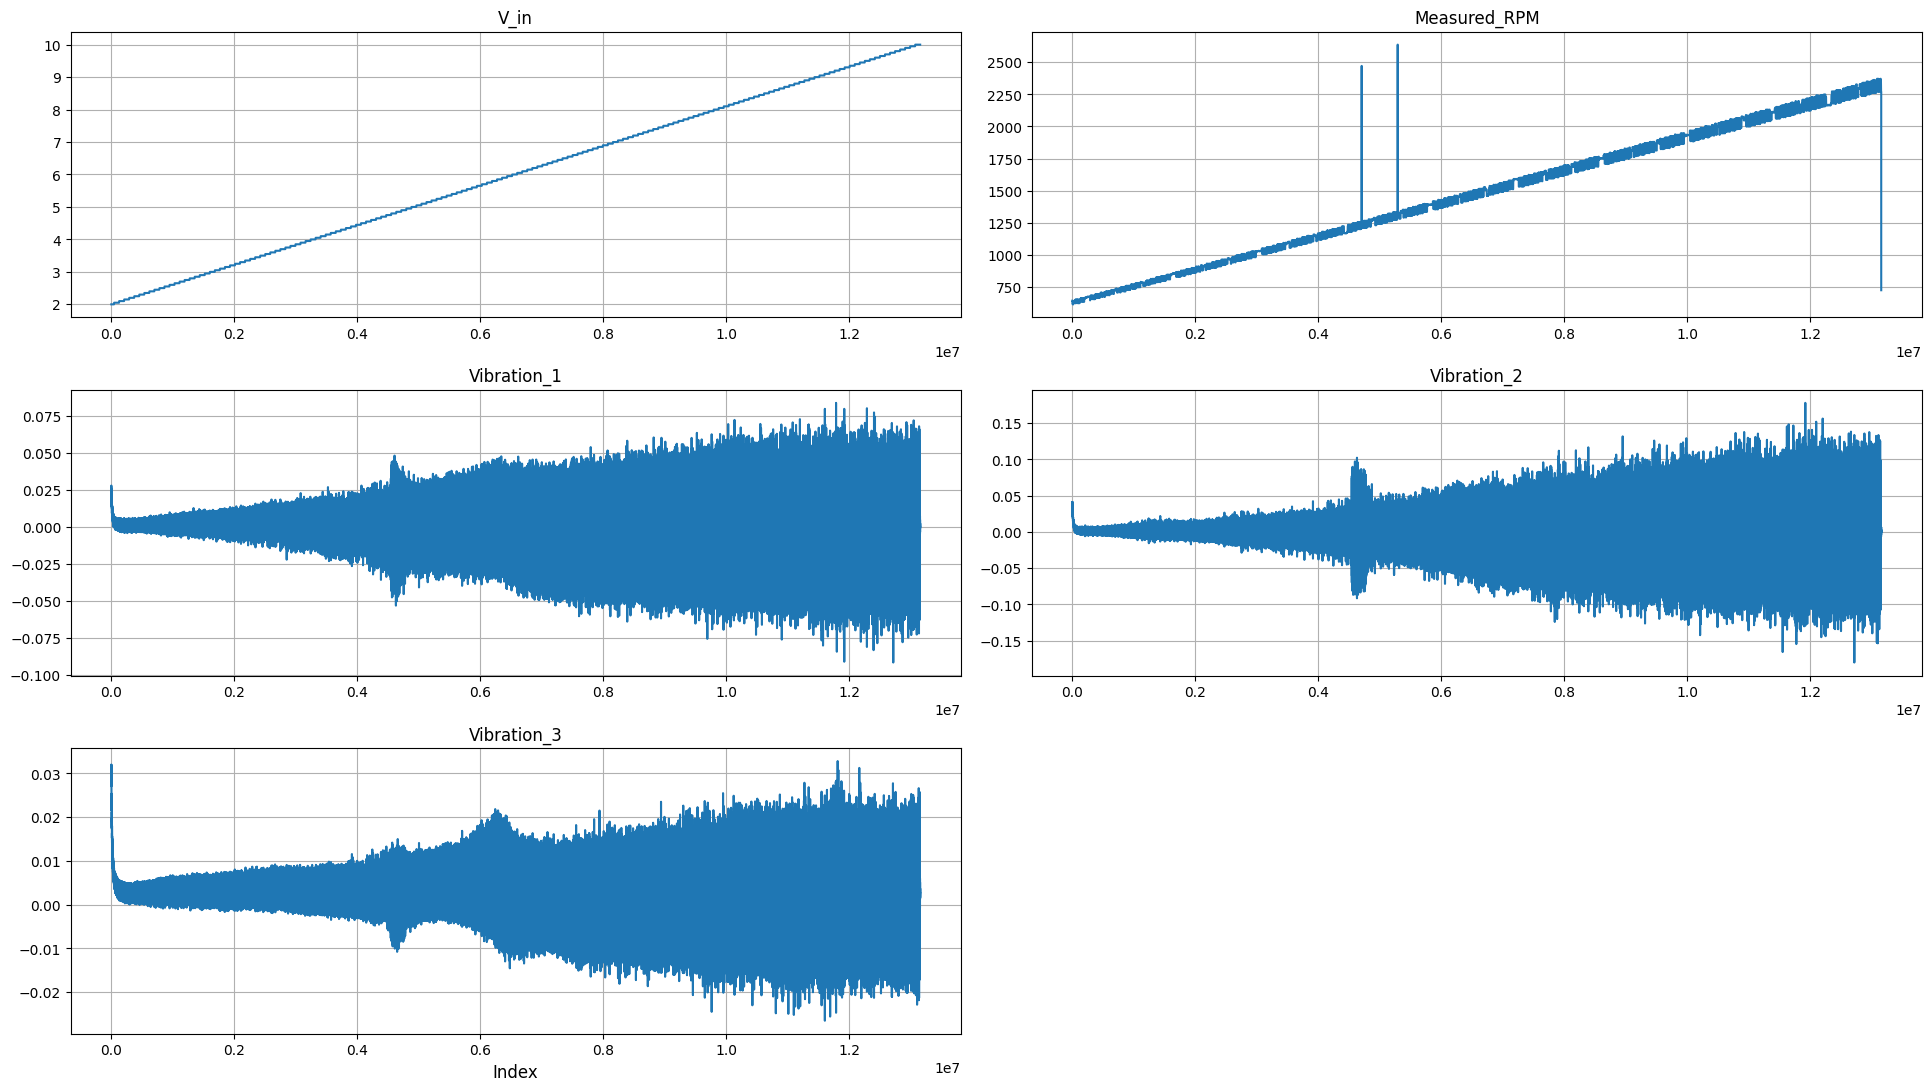

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\1D_1.csv


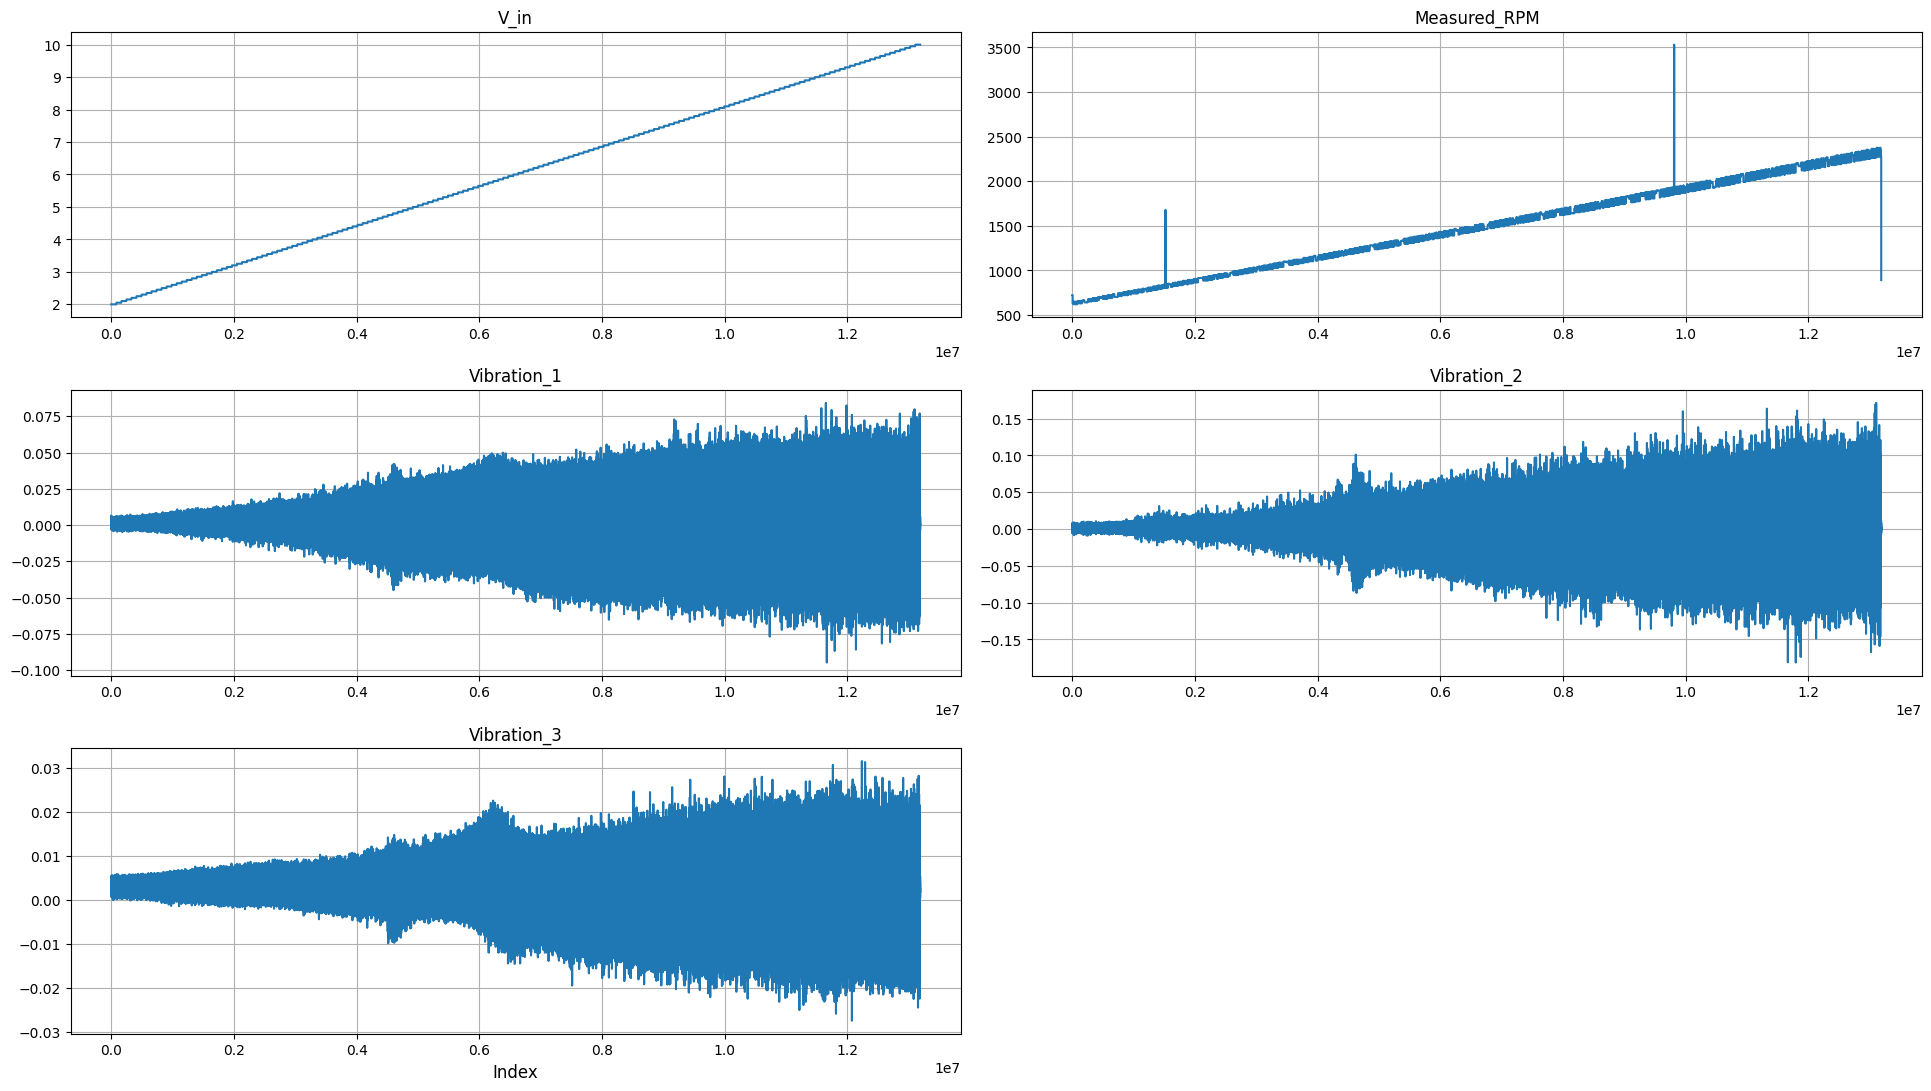

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\2D_0.csv


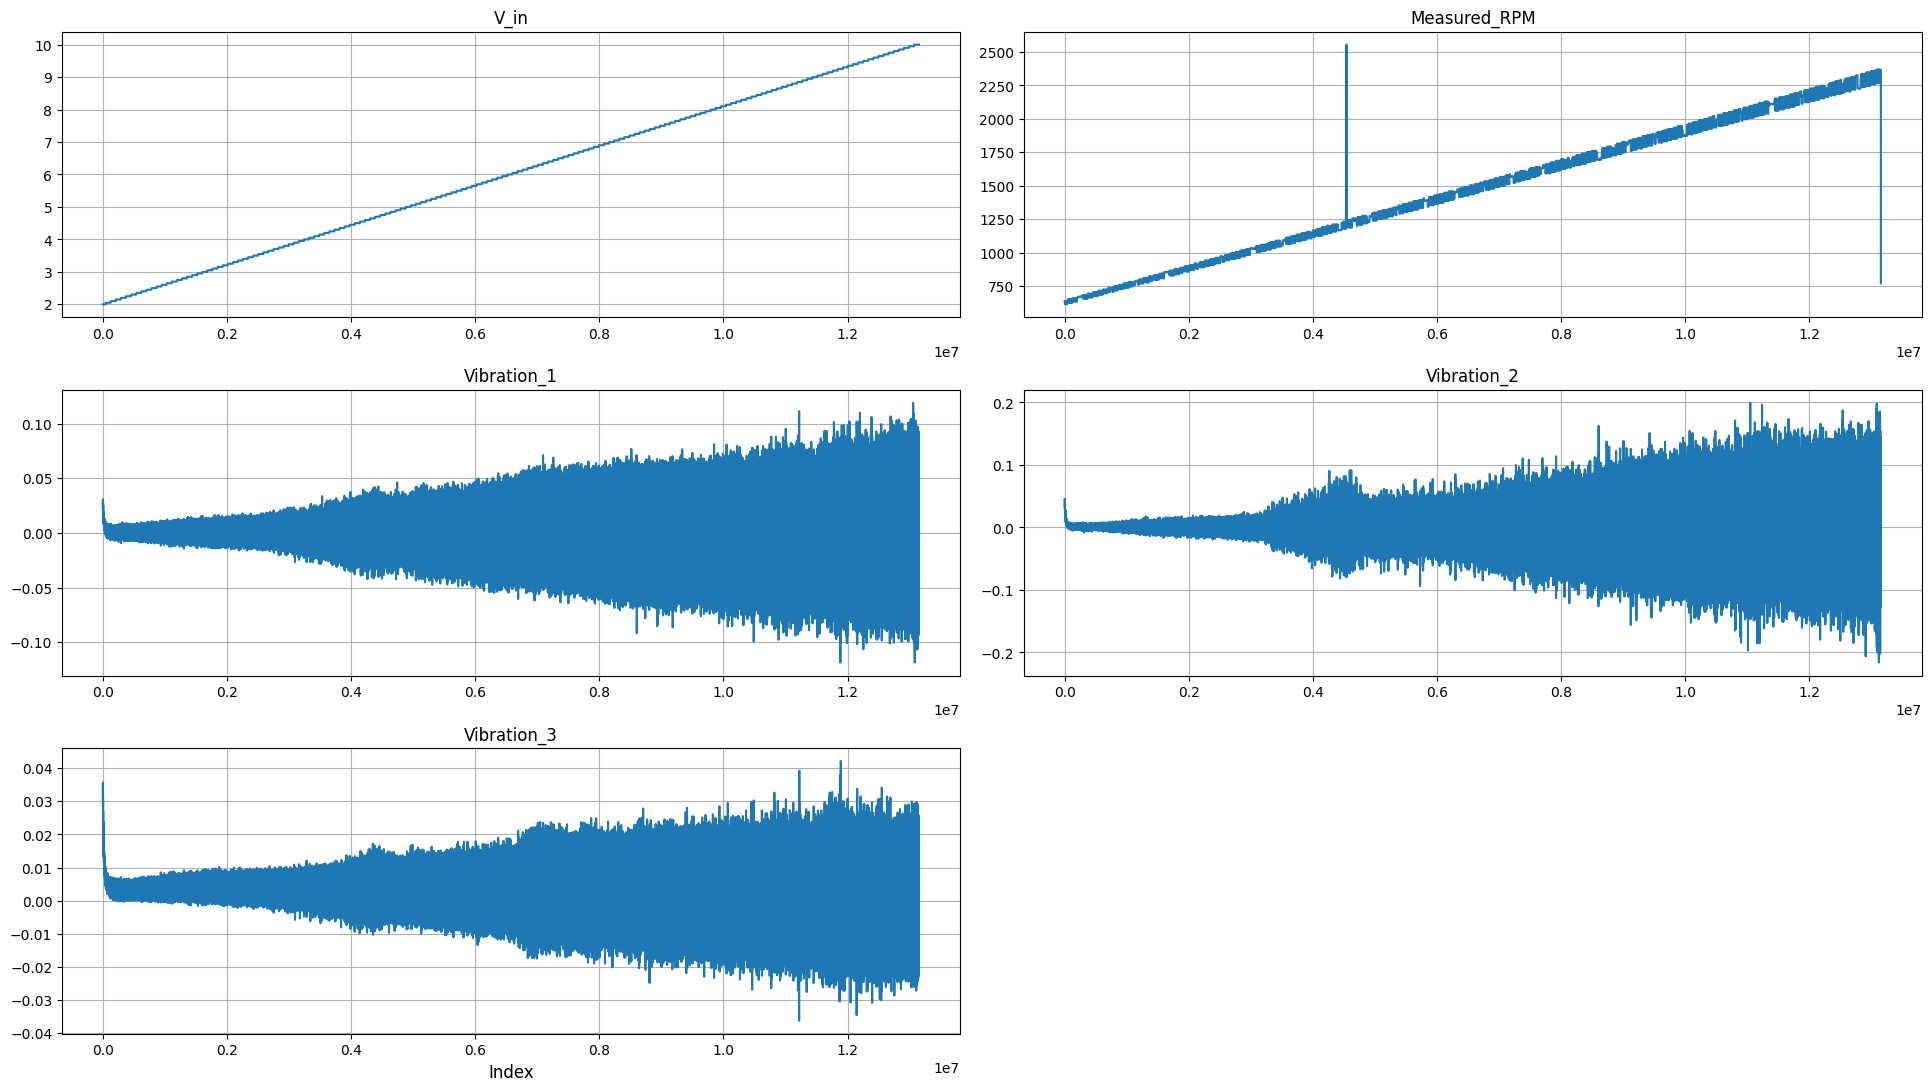

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\2D_1.csv


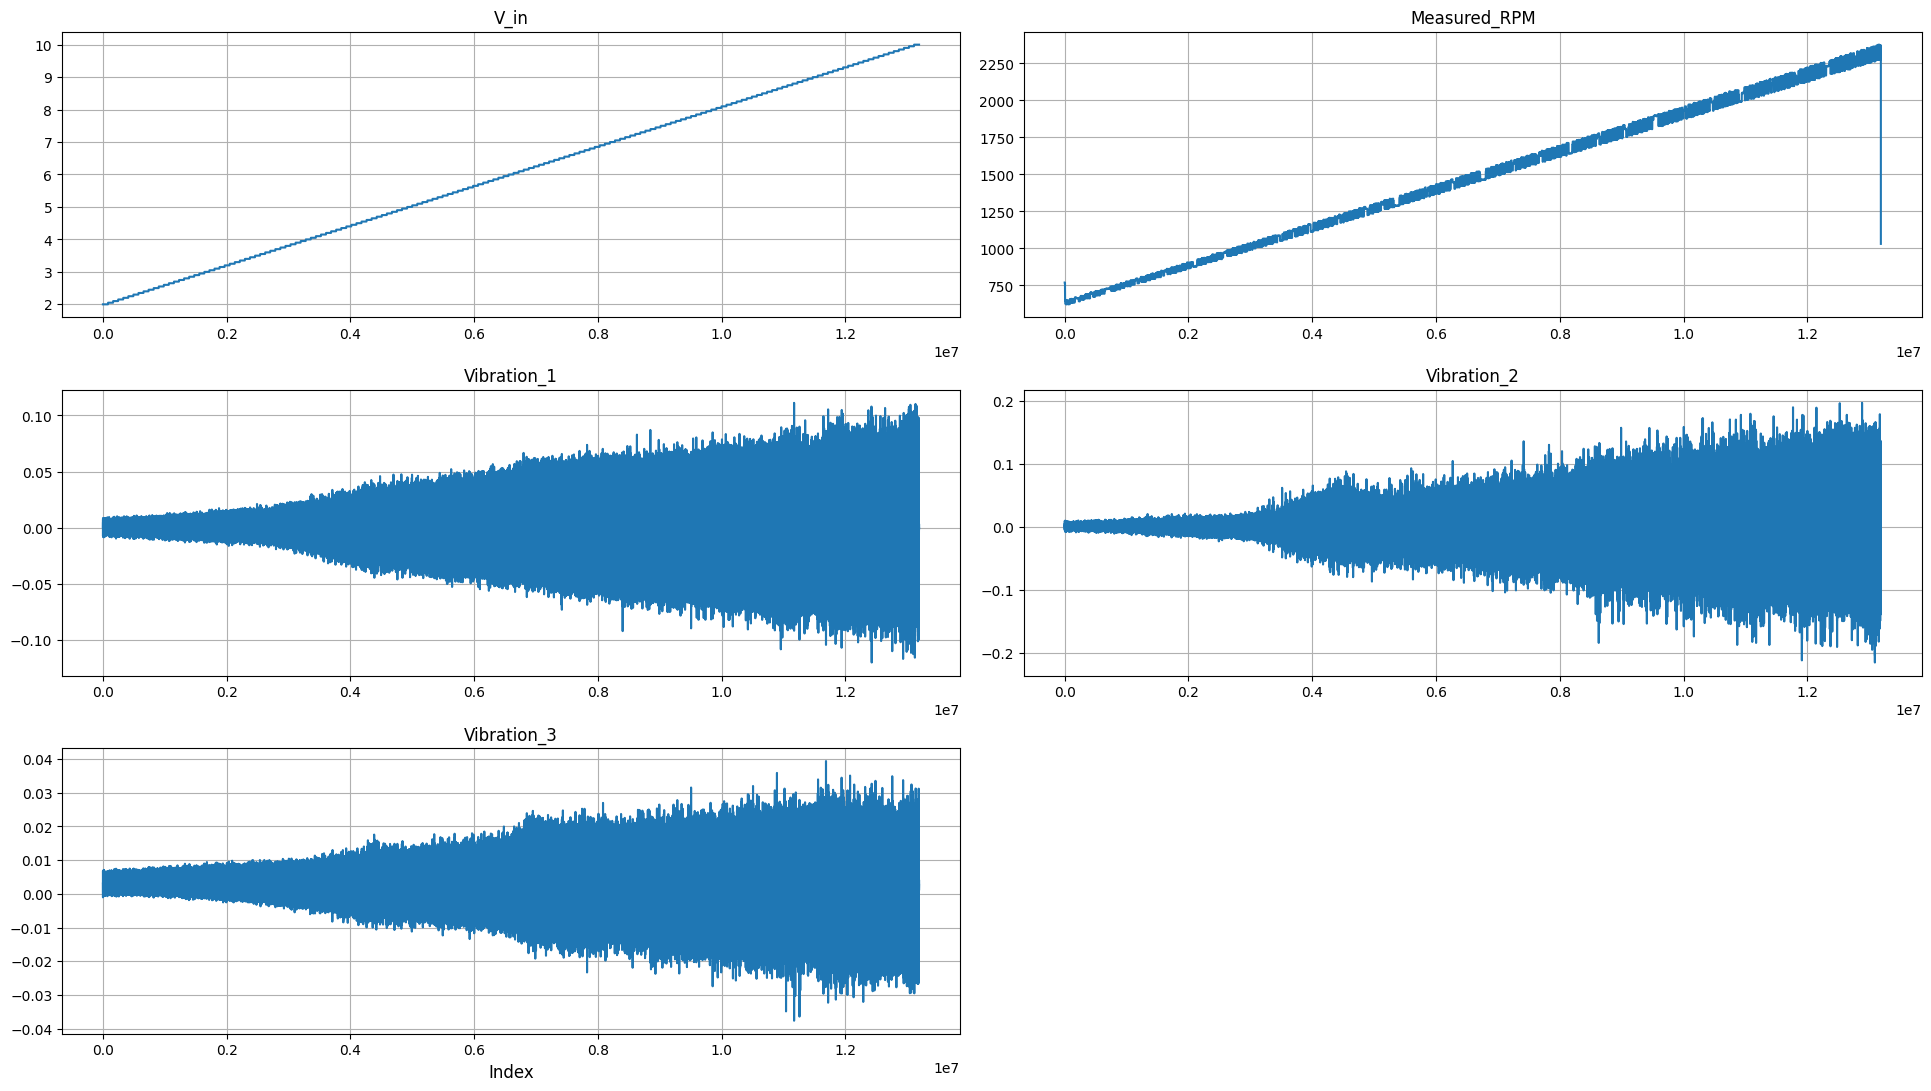

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\3D_0.csv


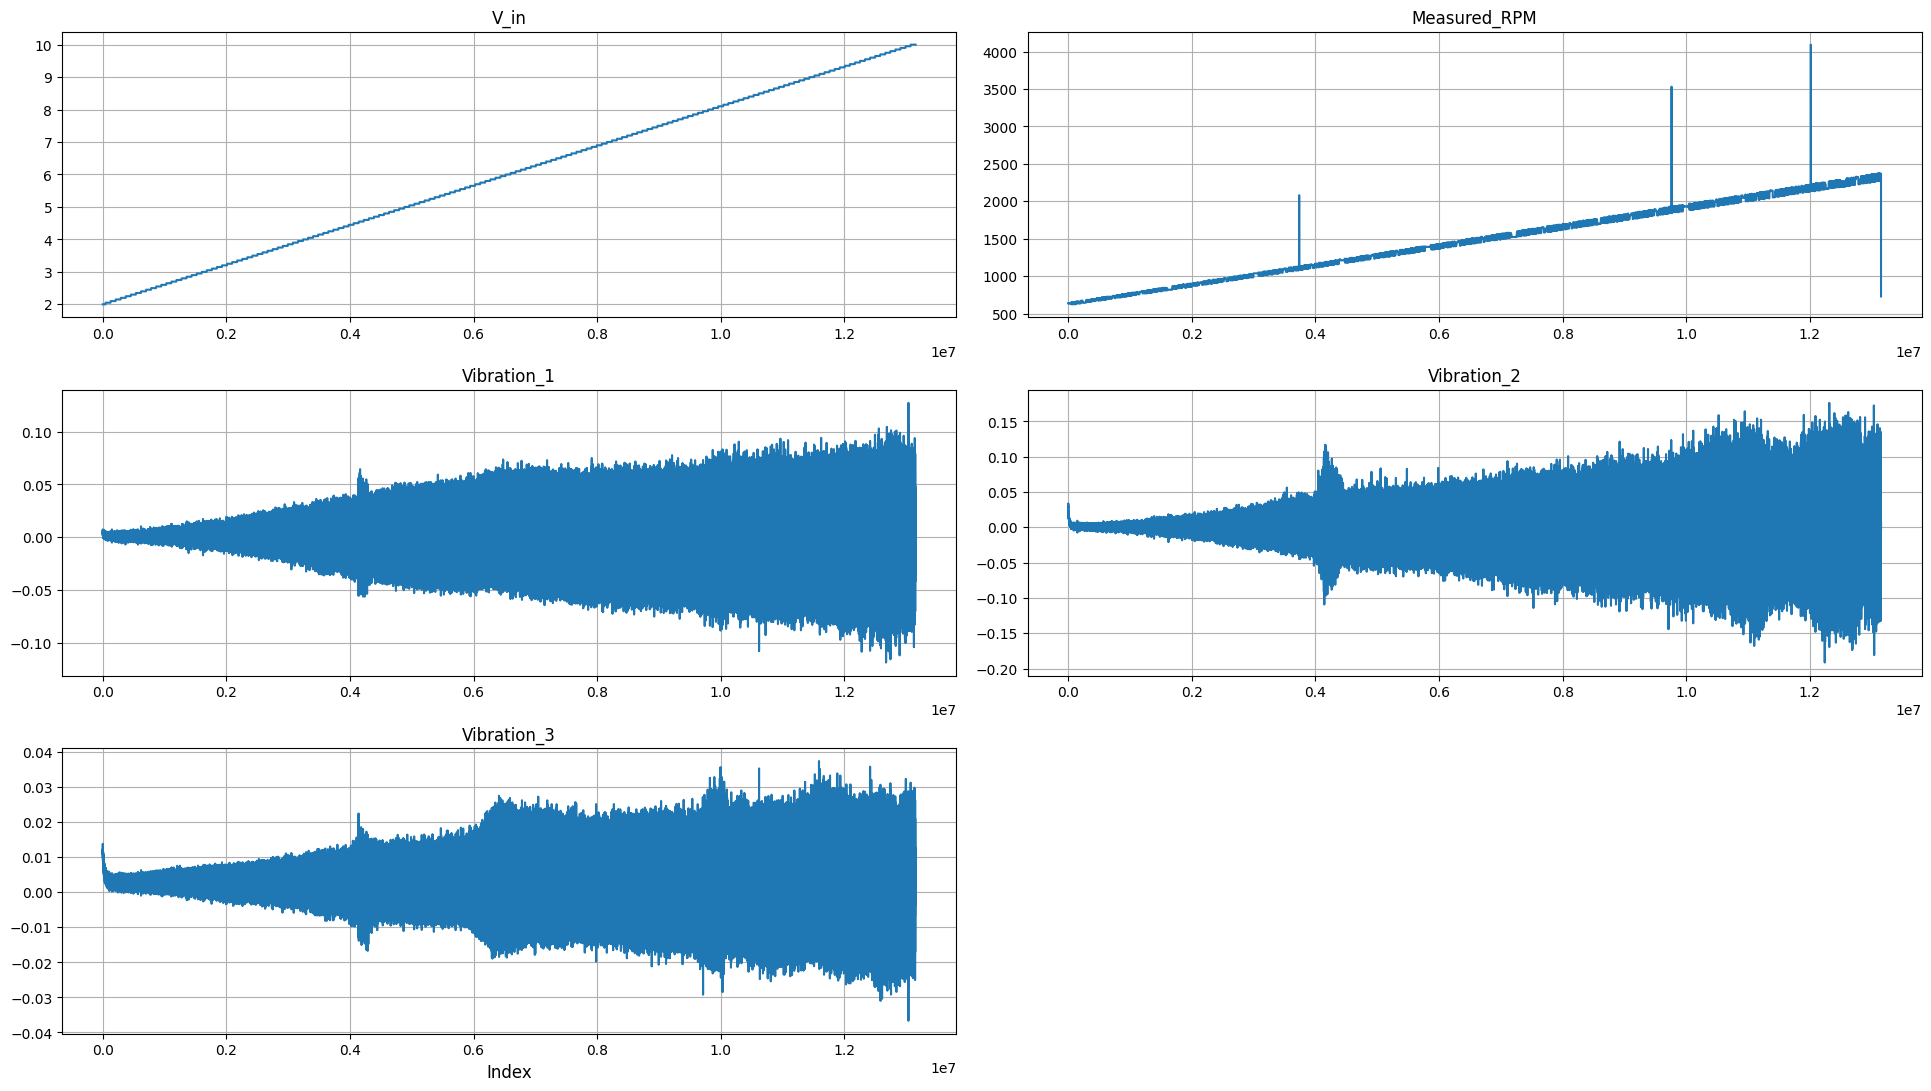

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\3D_1.csv


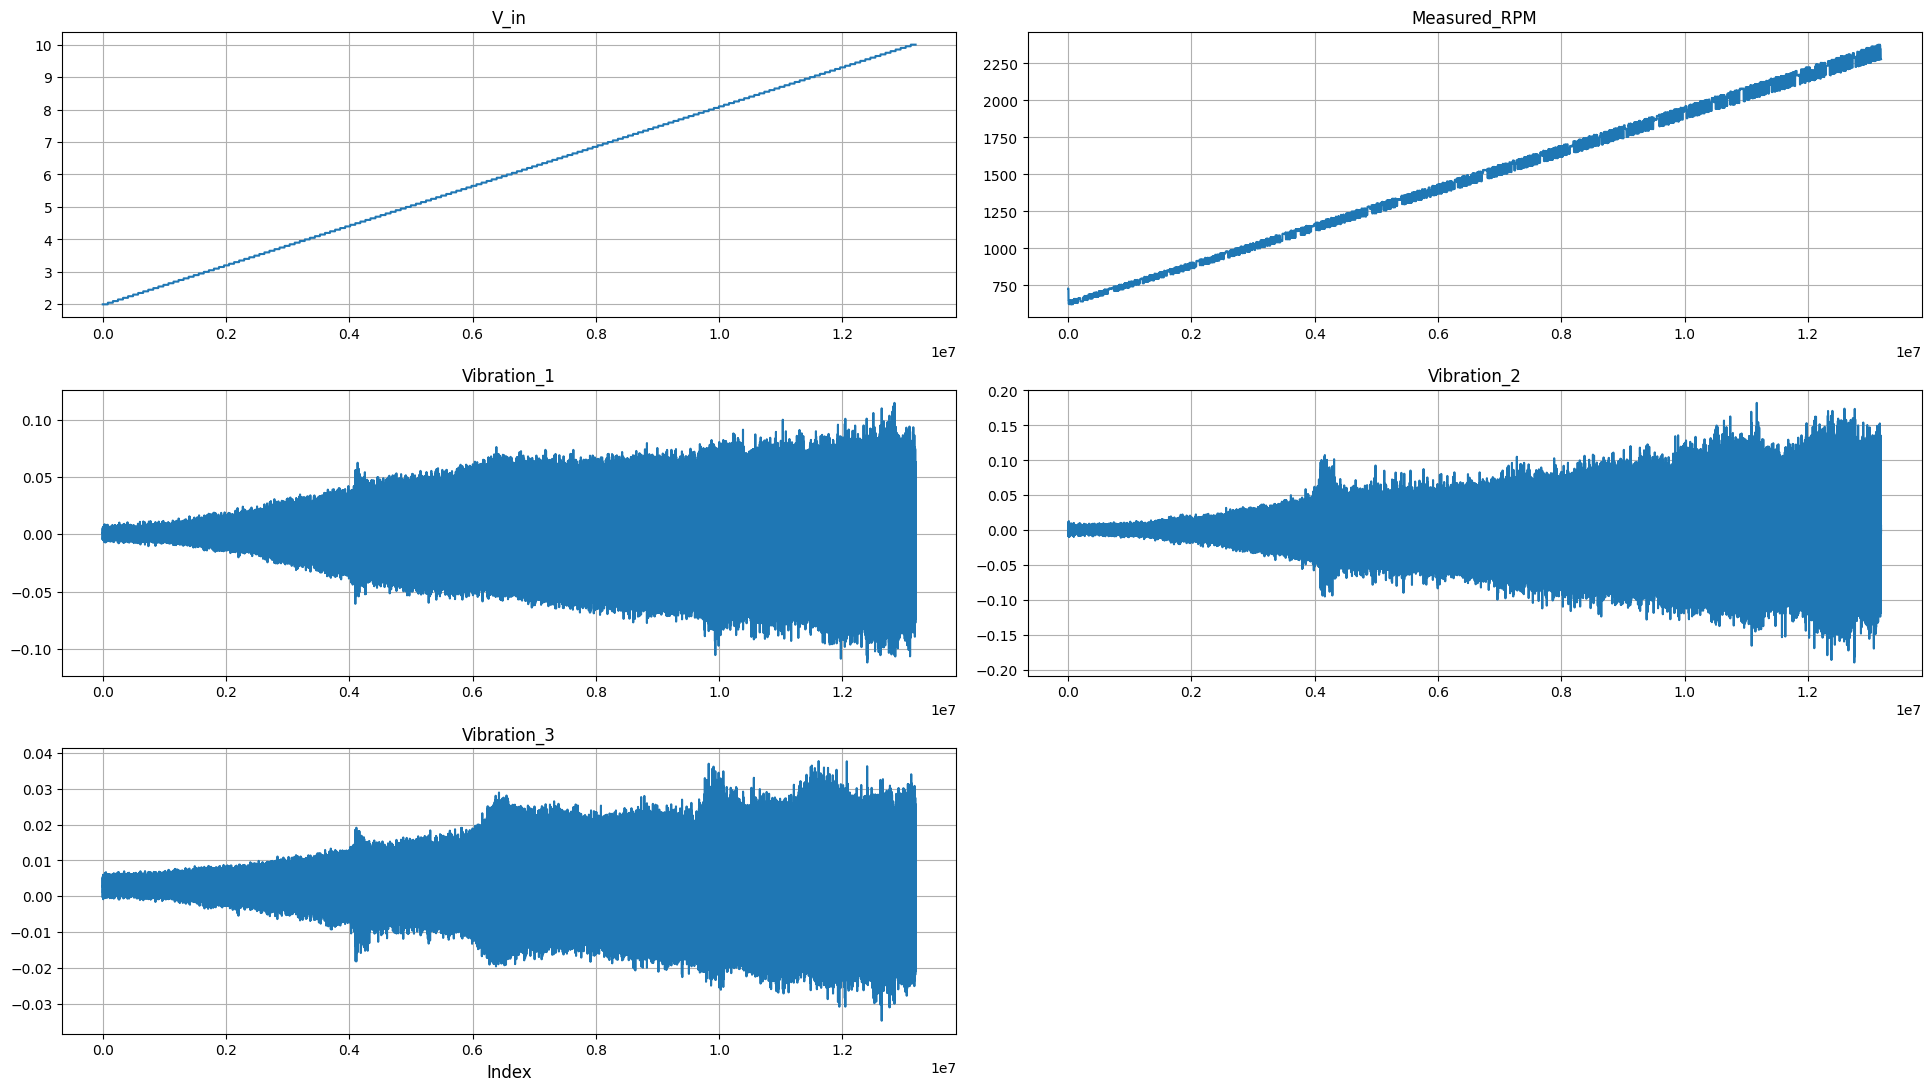

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\4D_0.csv


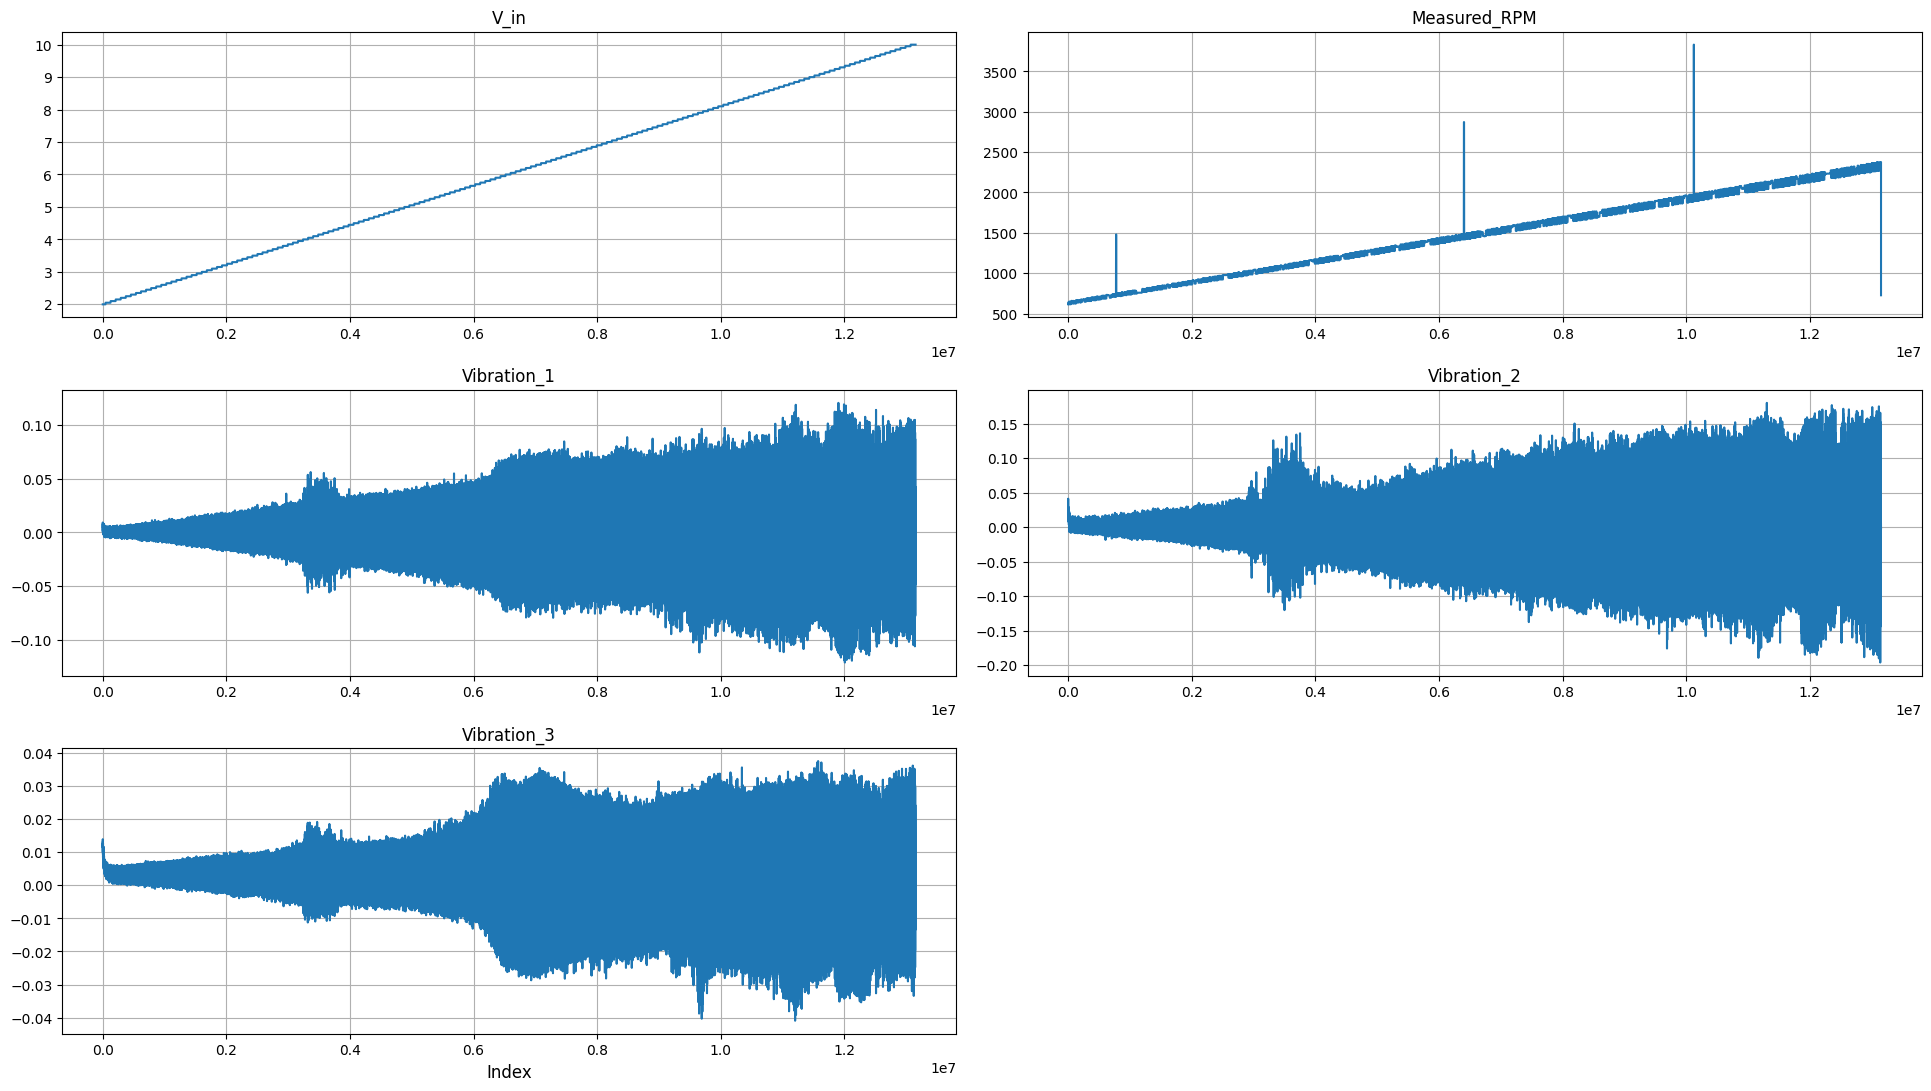

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\4D_1.csv


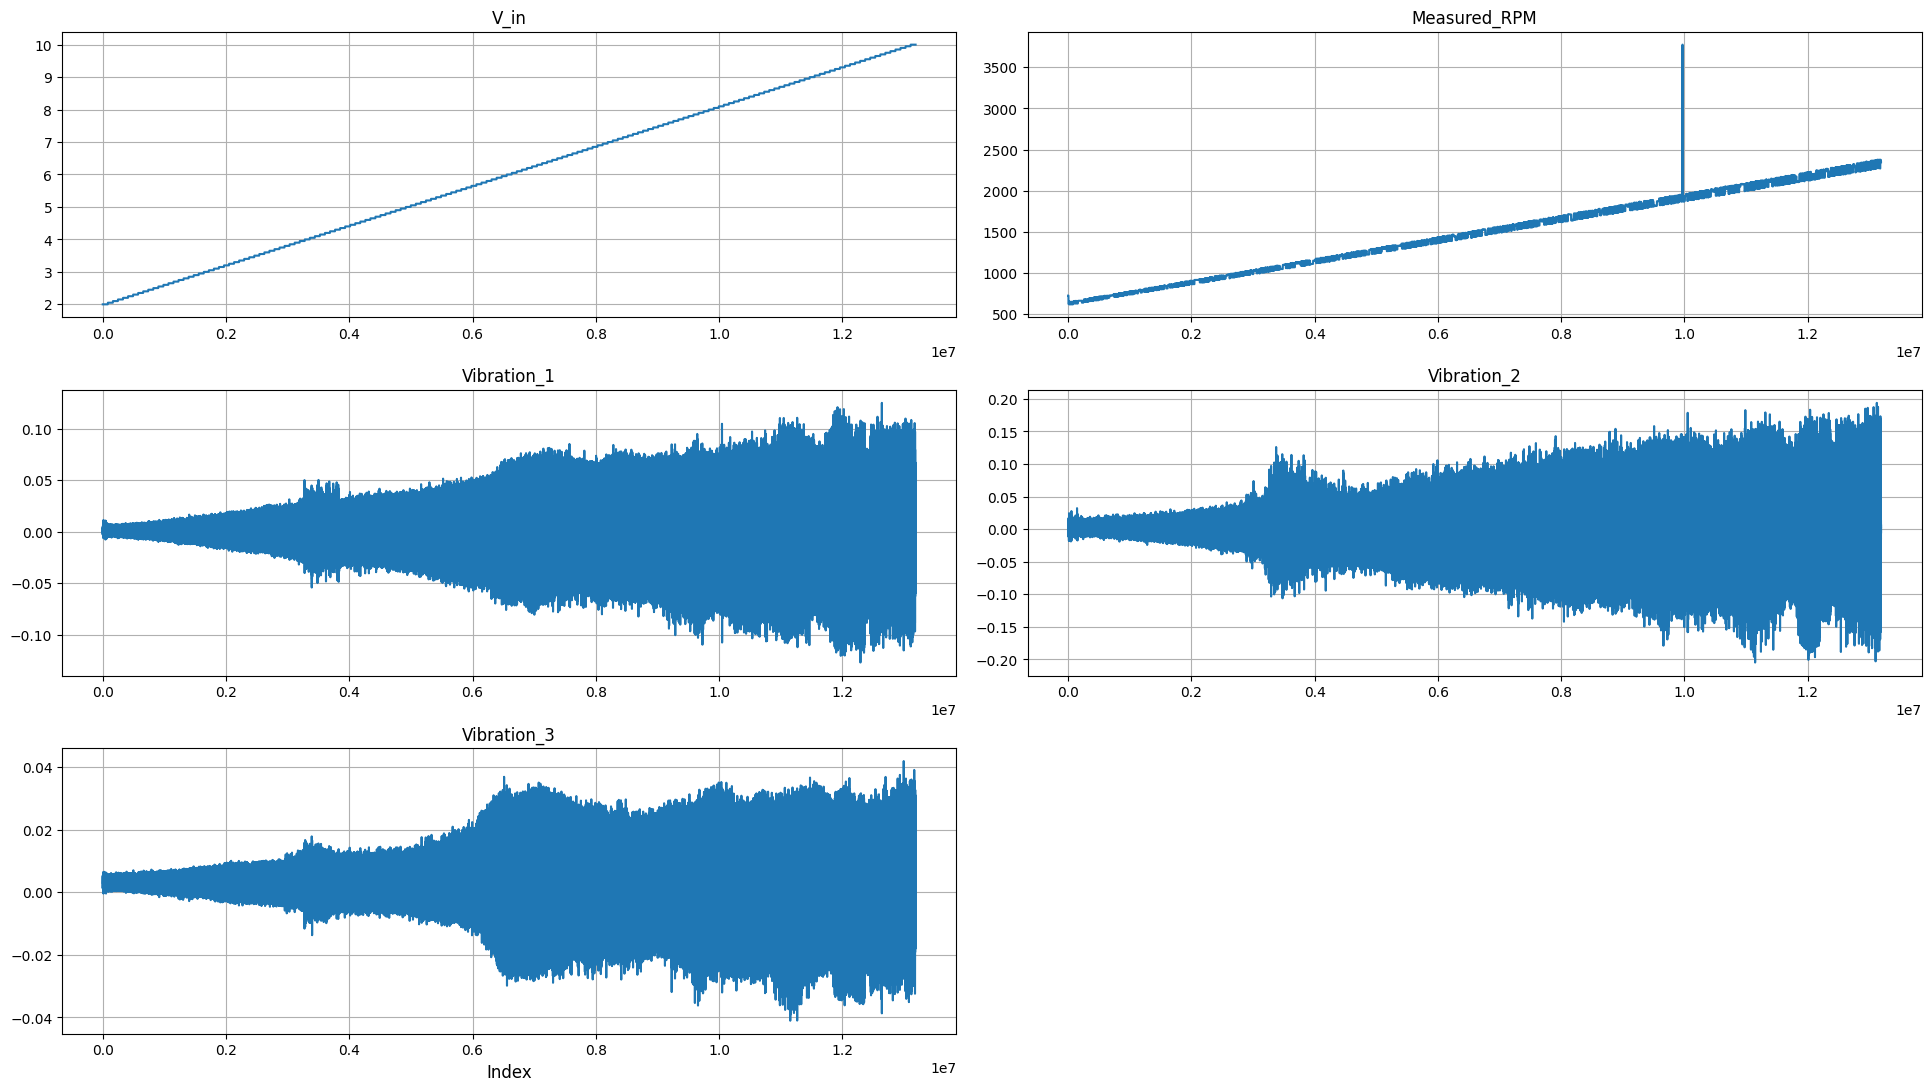

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\0E_0.csv


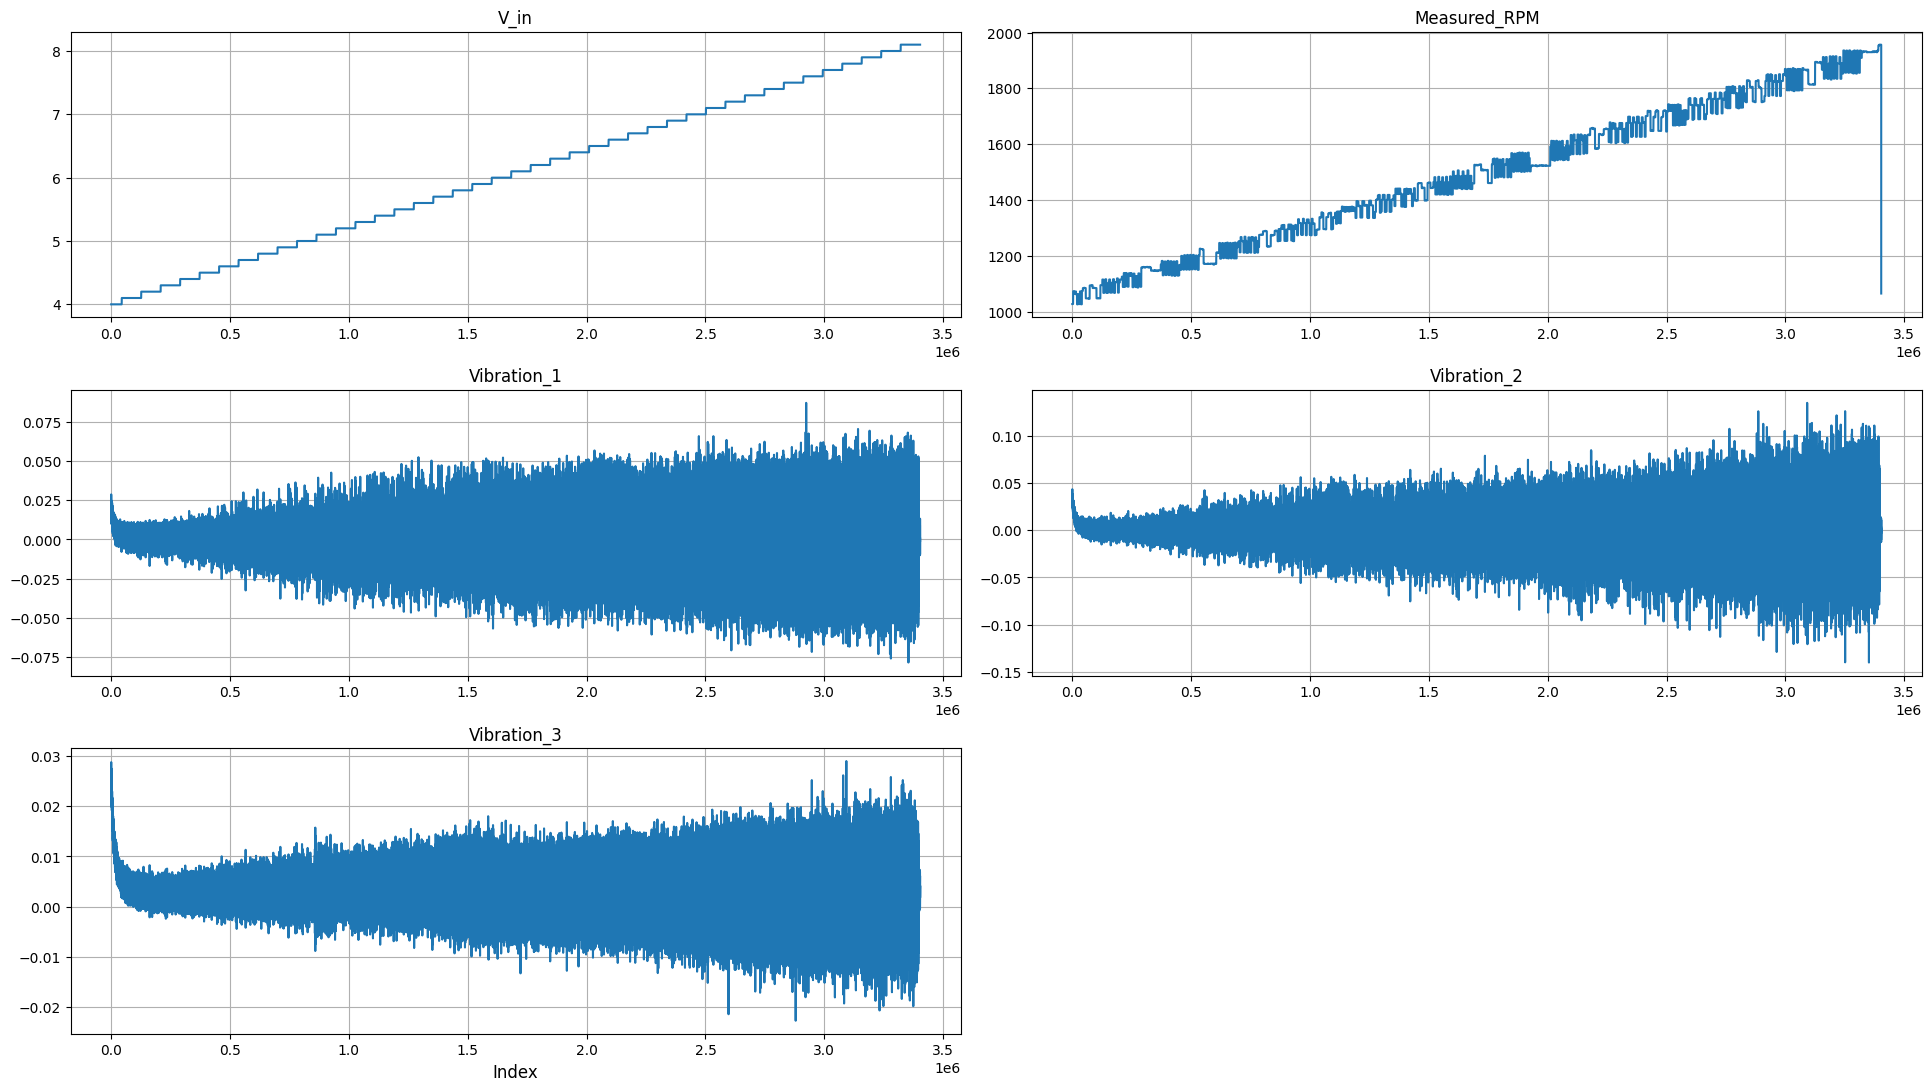

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\0E_1.csv


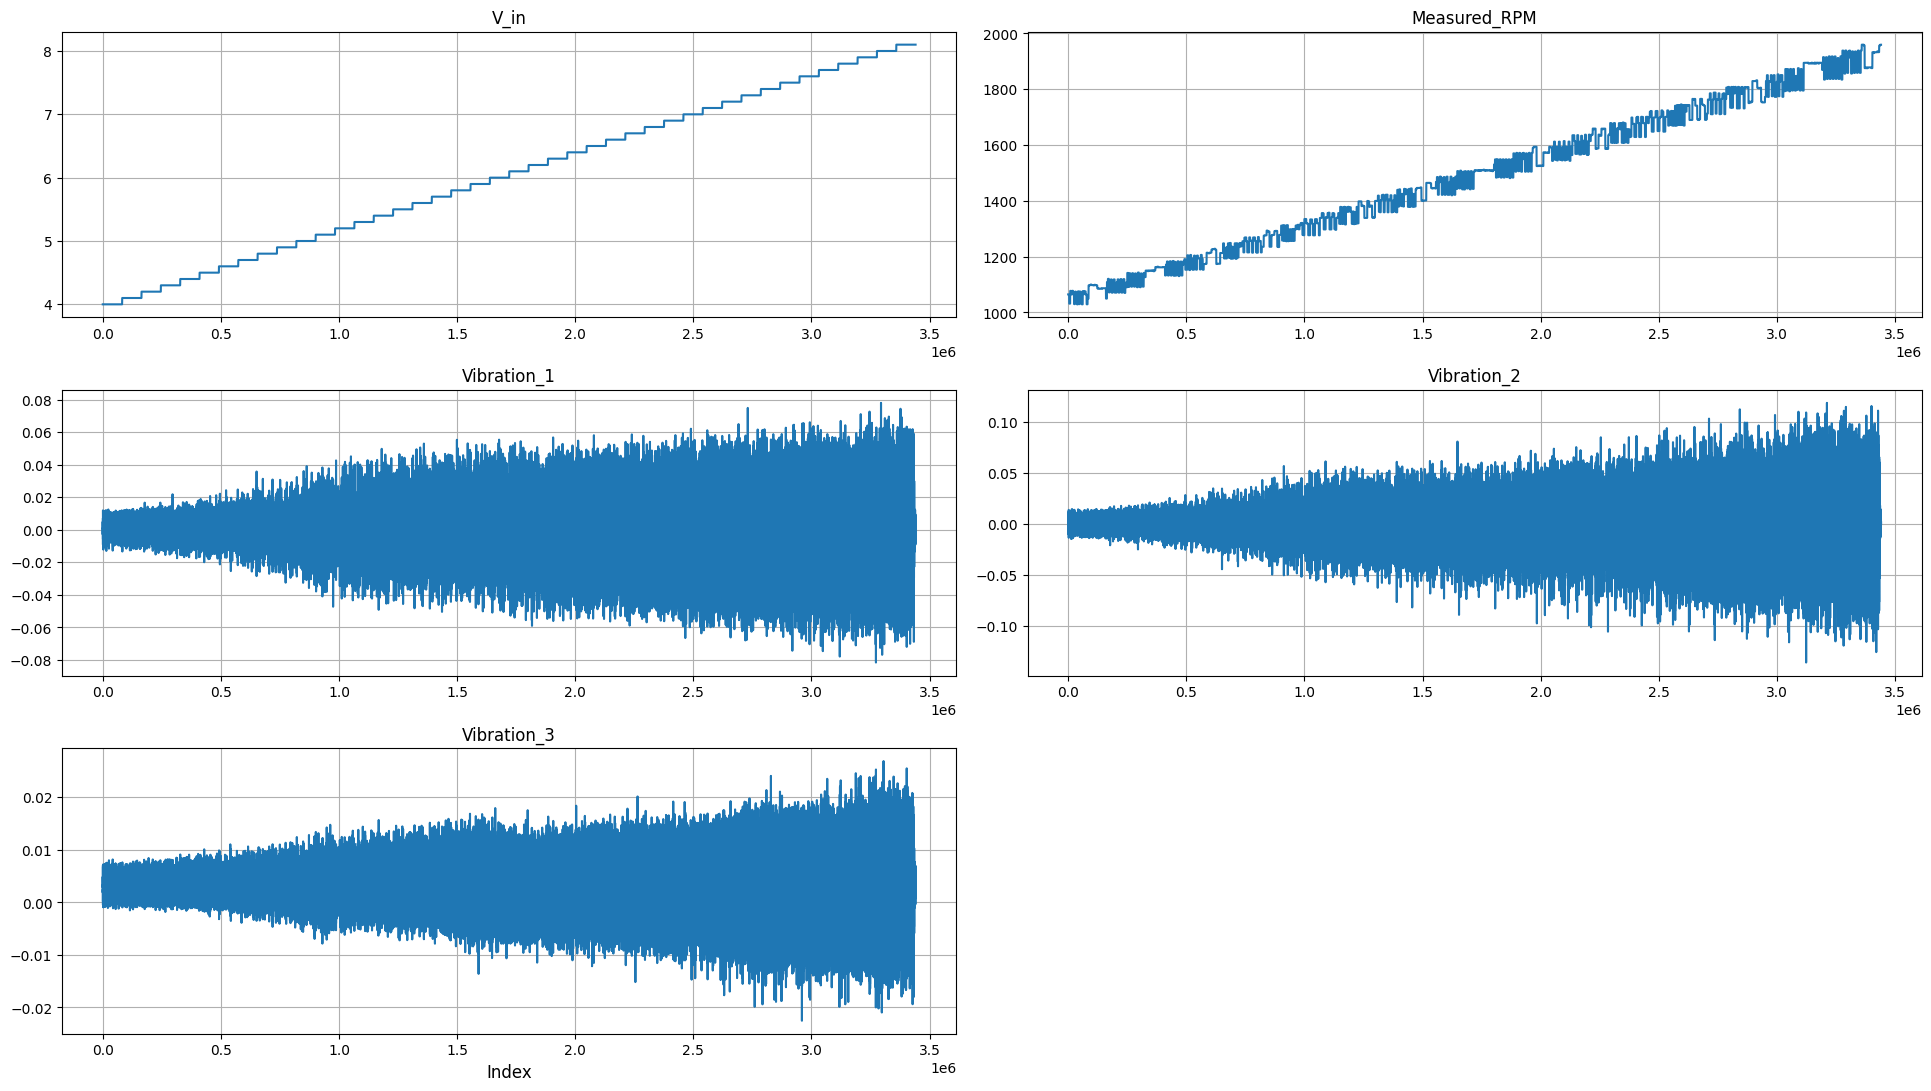

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\1E_0.csv


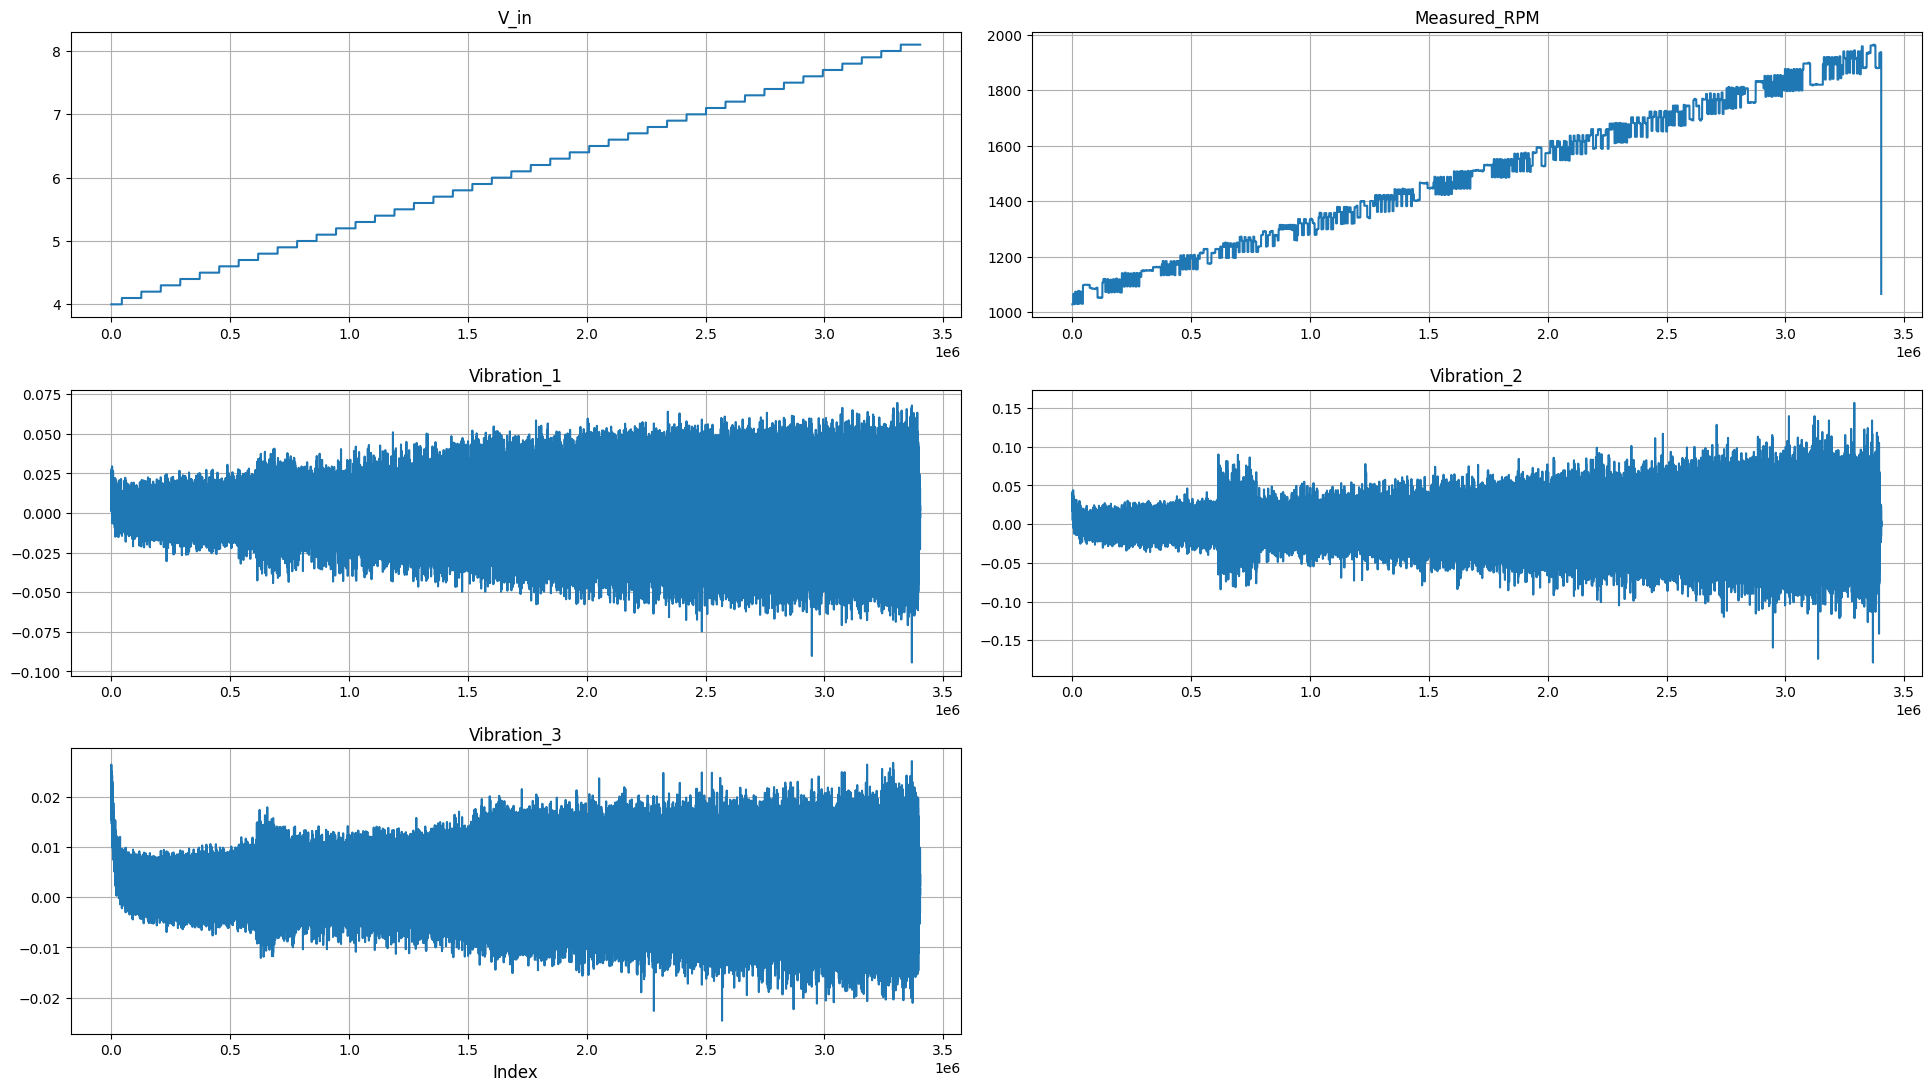

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\1E_1.csv


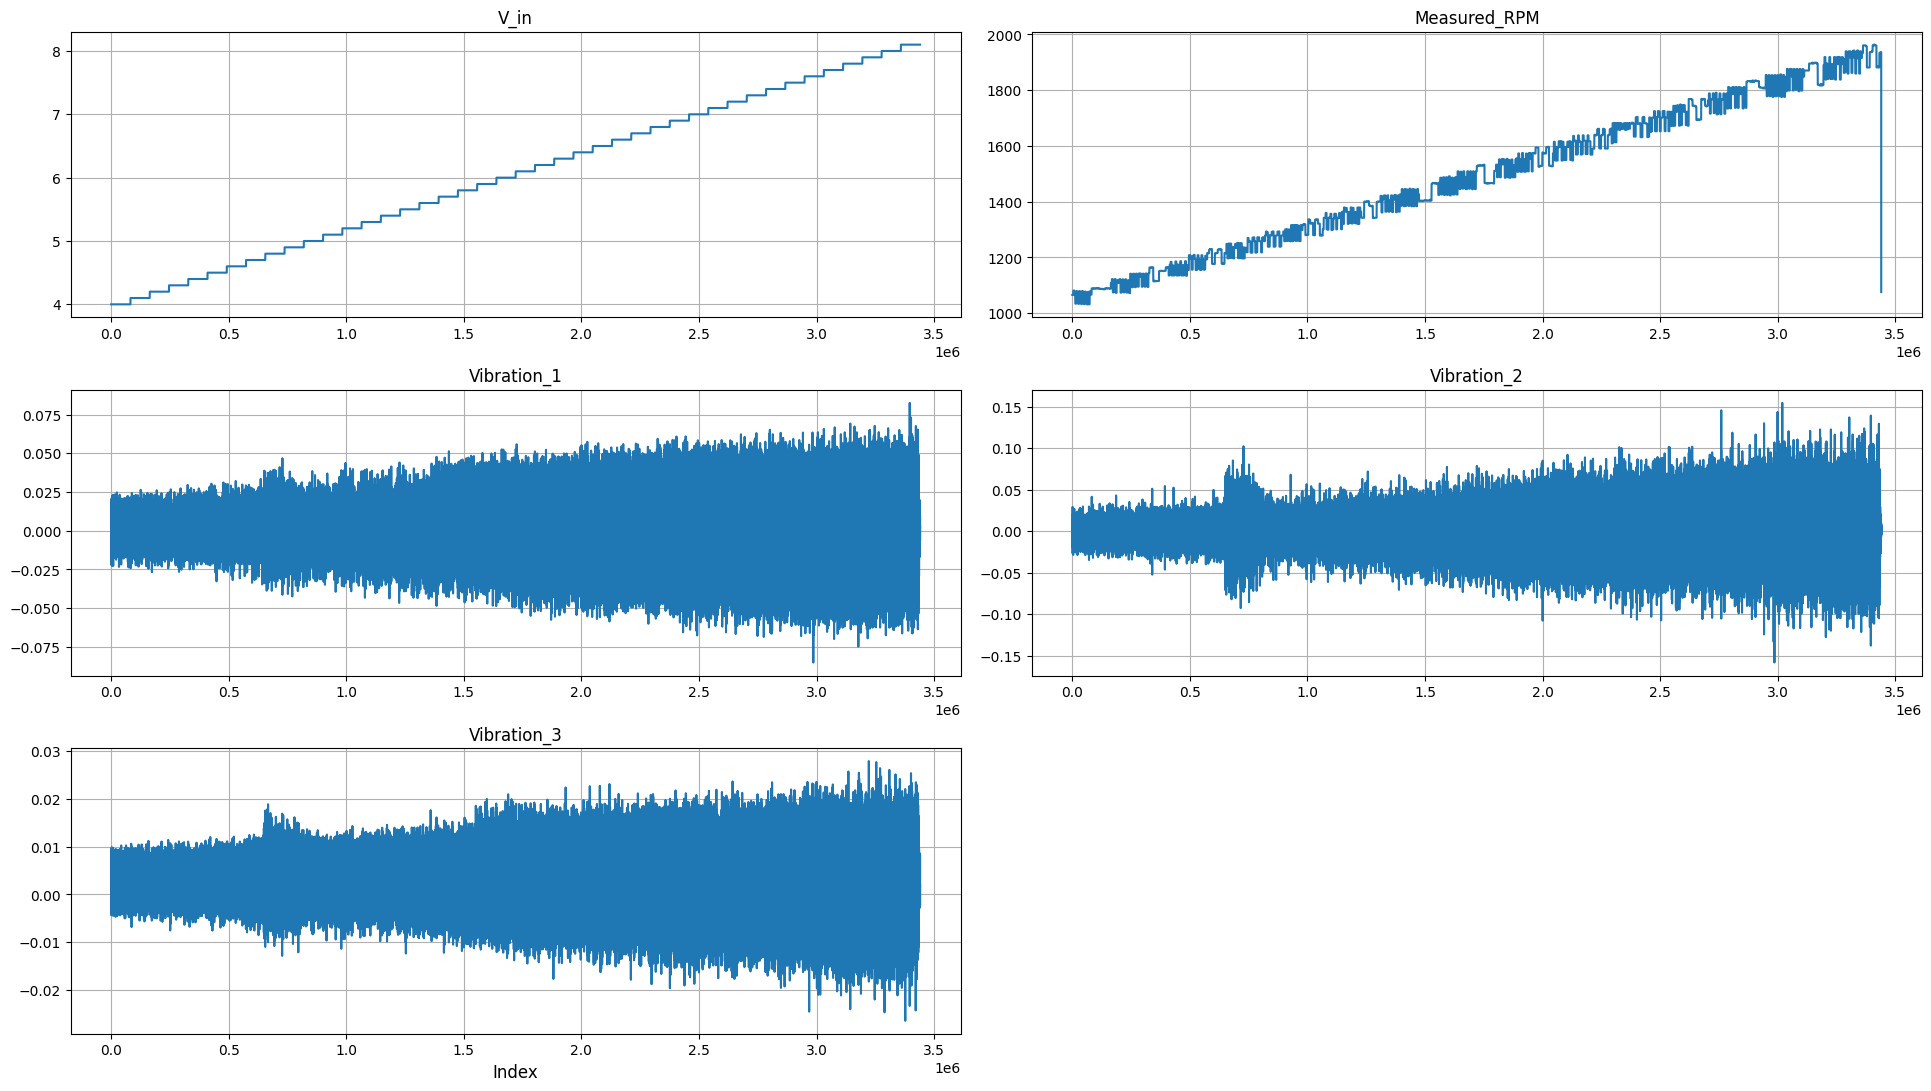

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\2E_0.csv


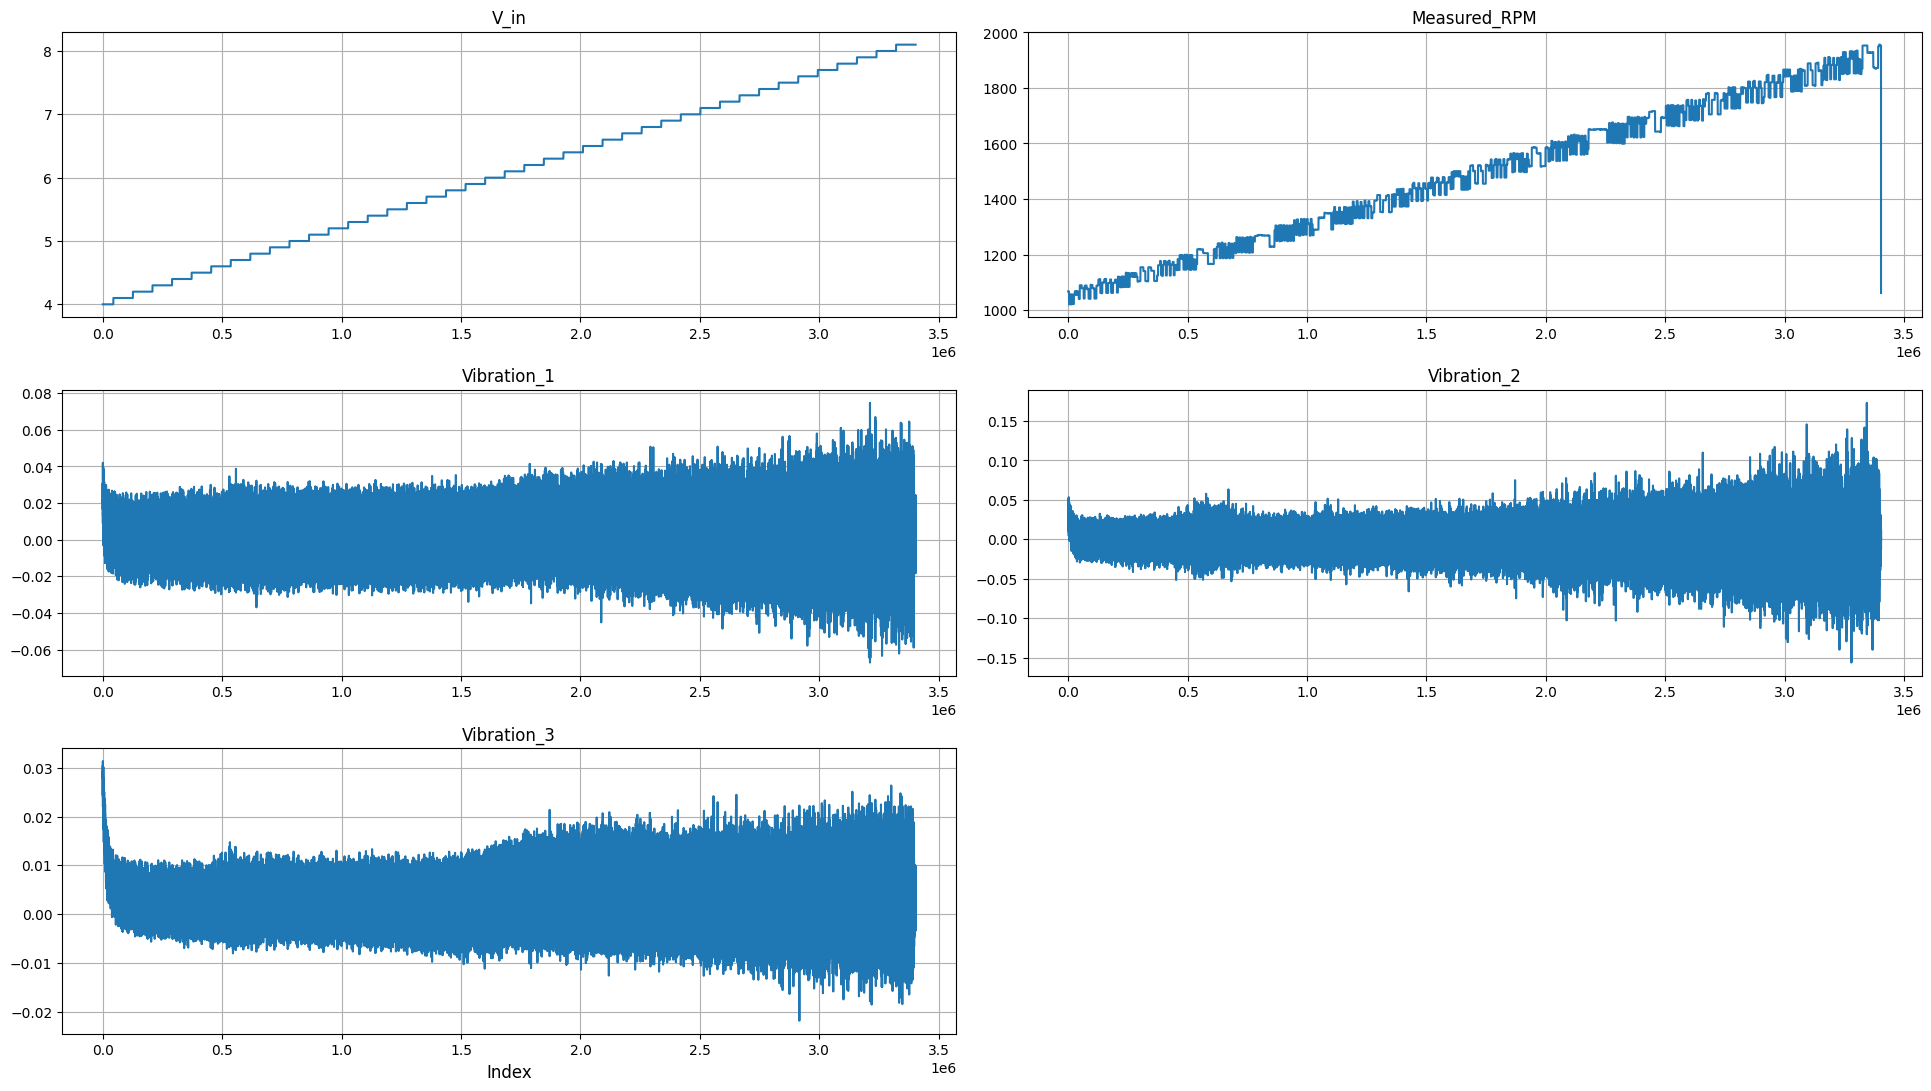

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\2E_1.csv


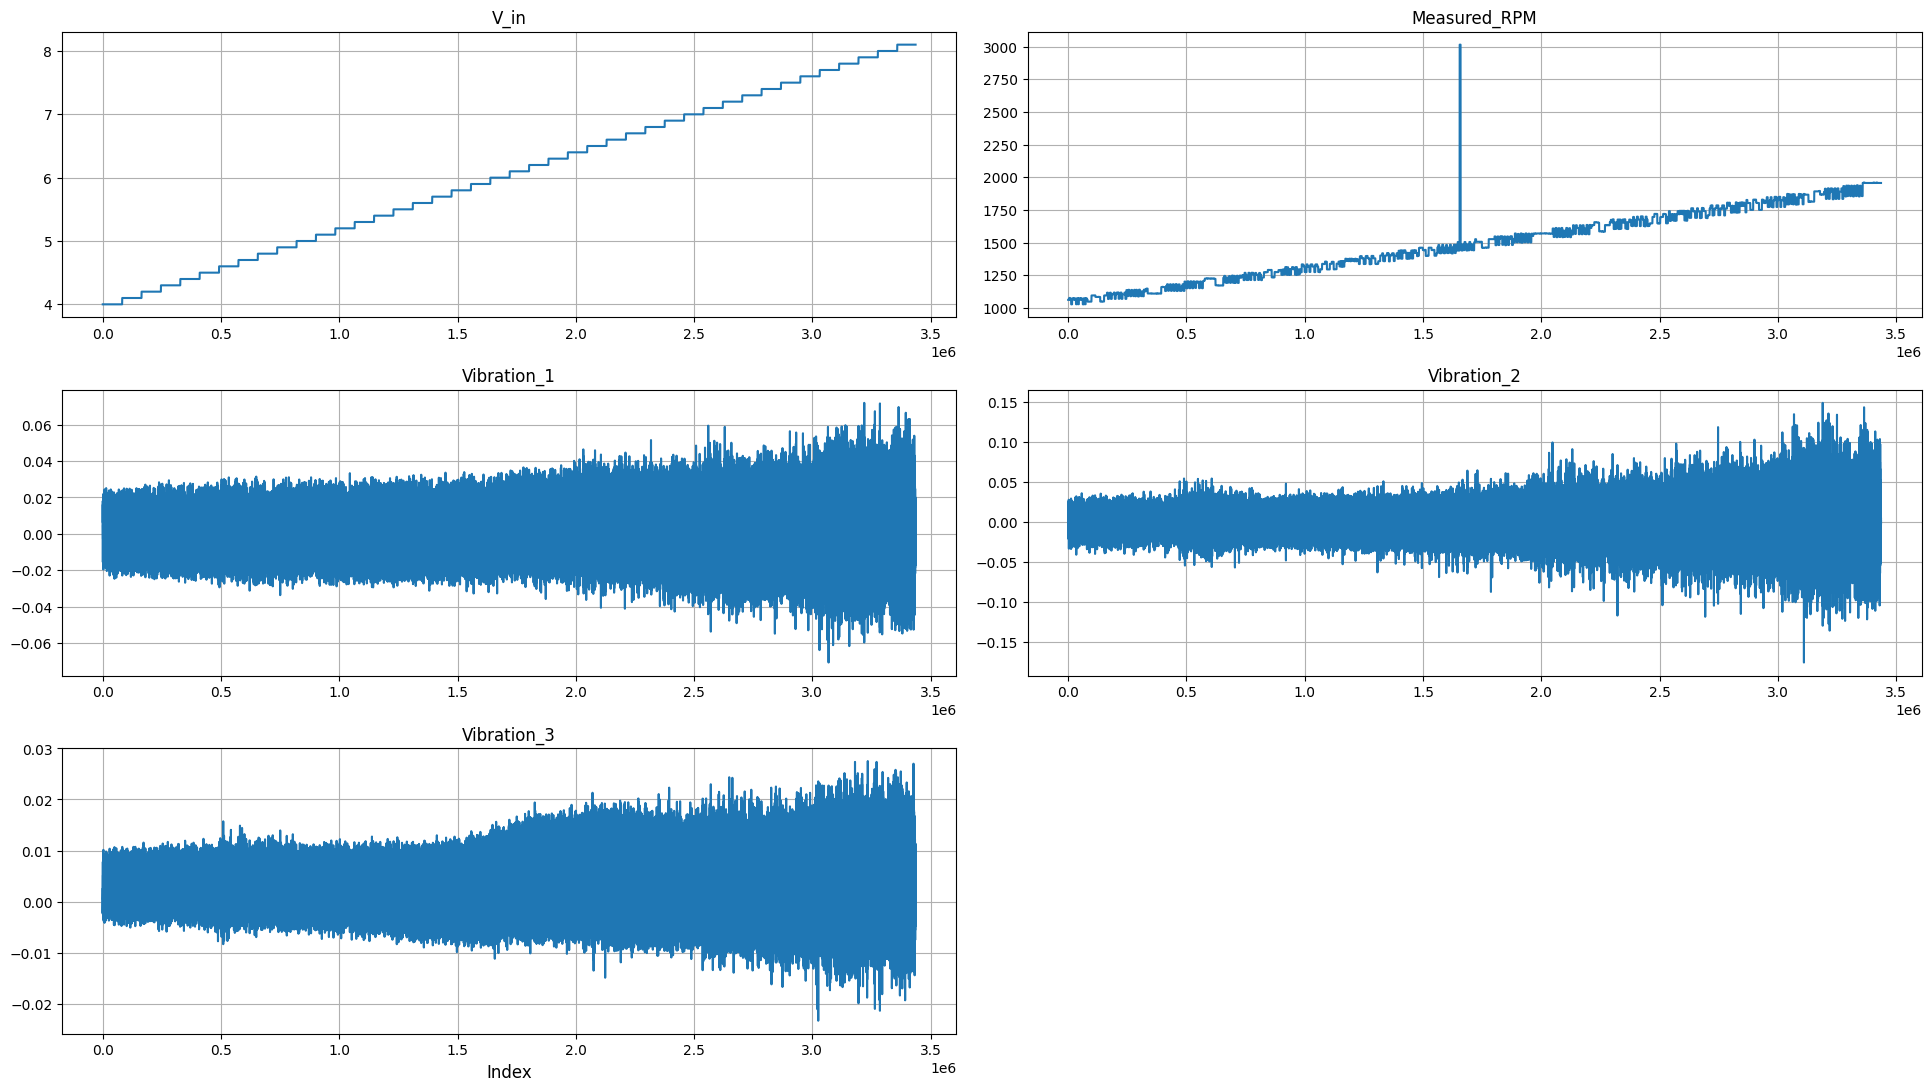

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\3E_0.csv


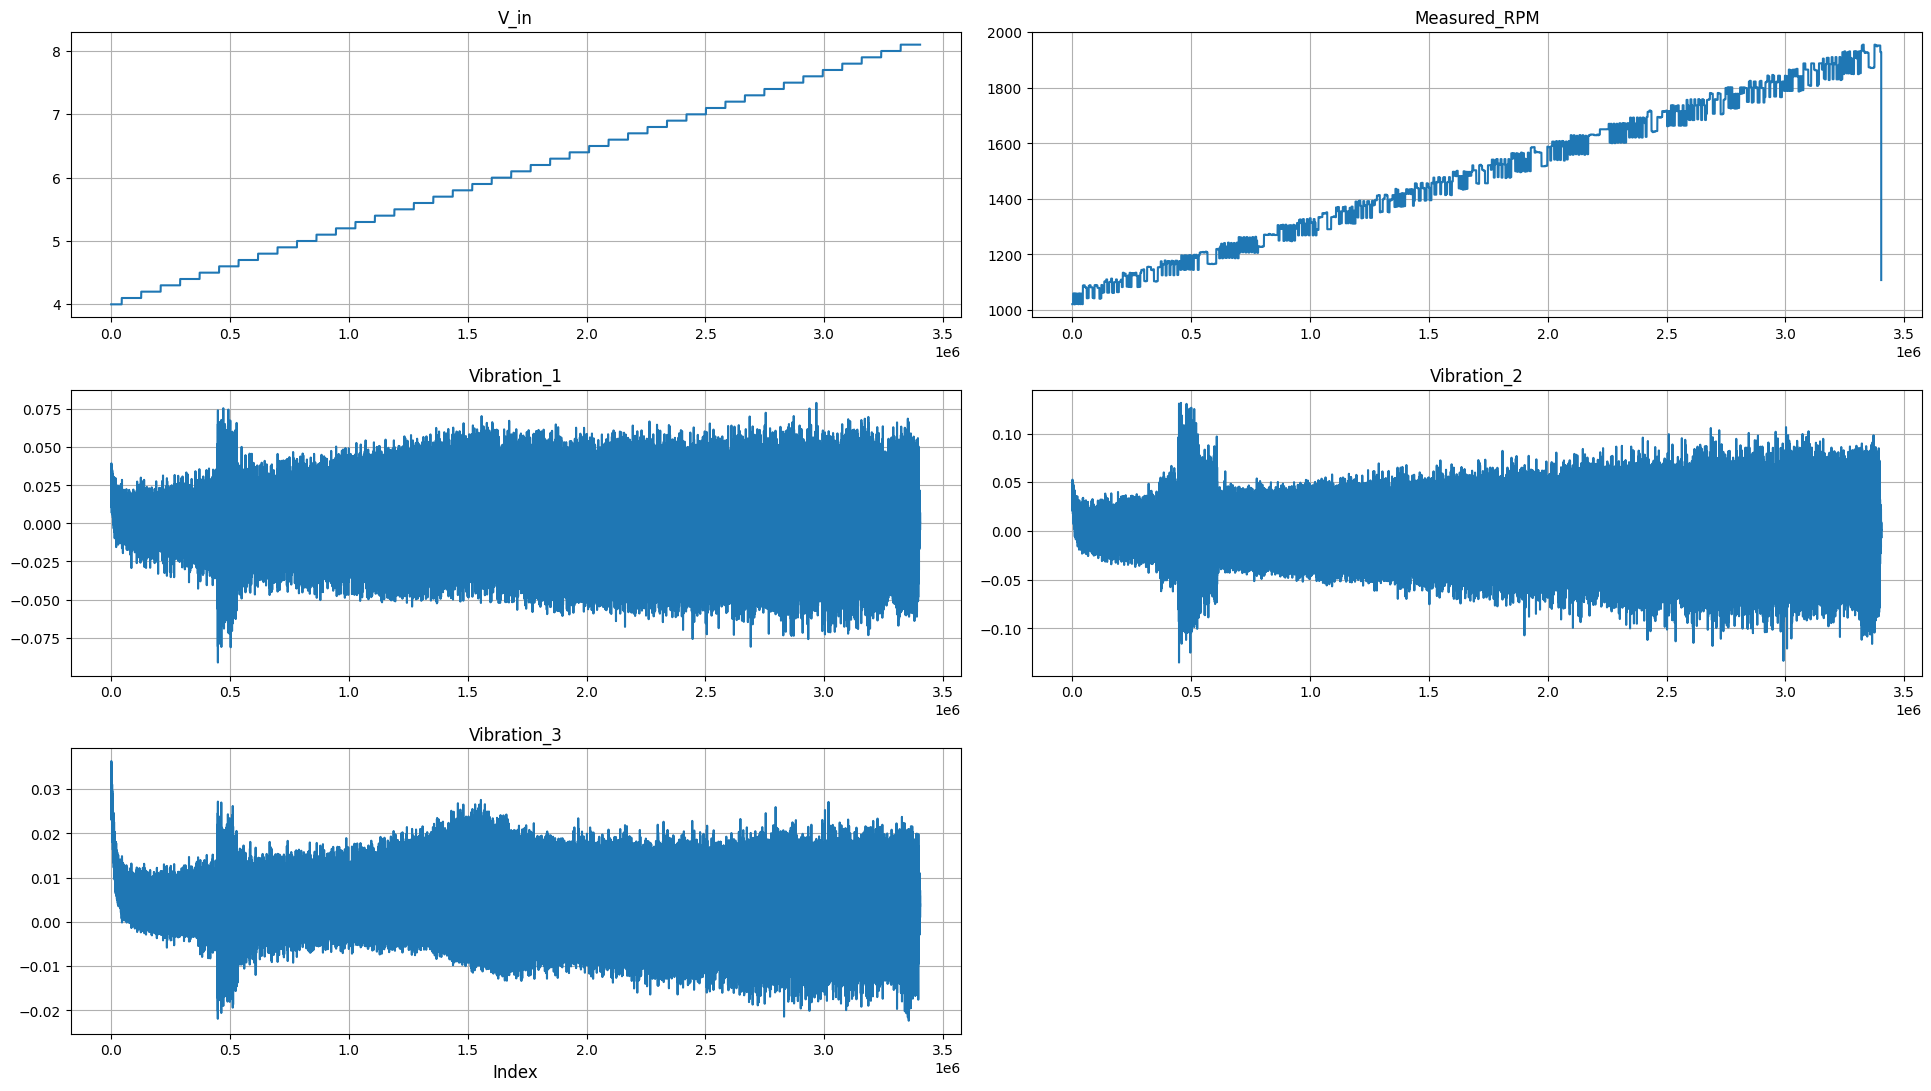

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\3E_1.csv


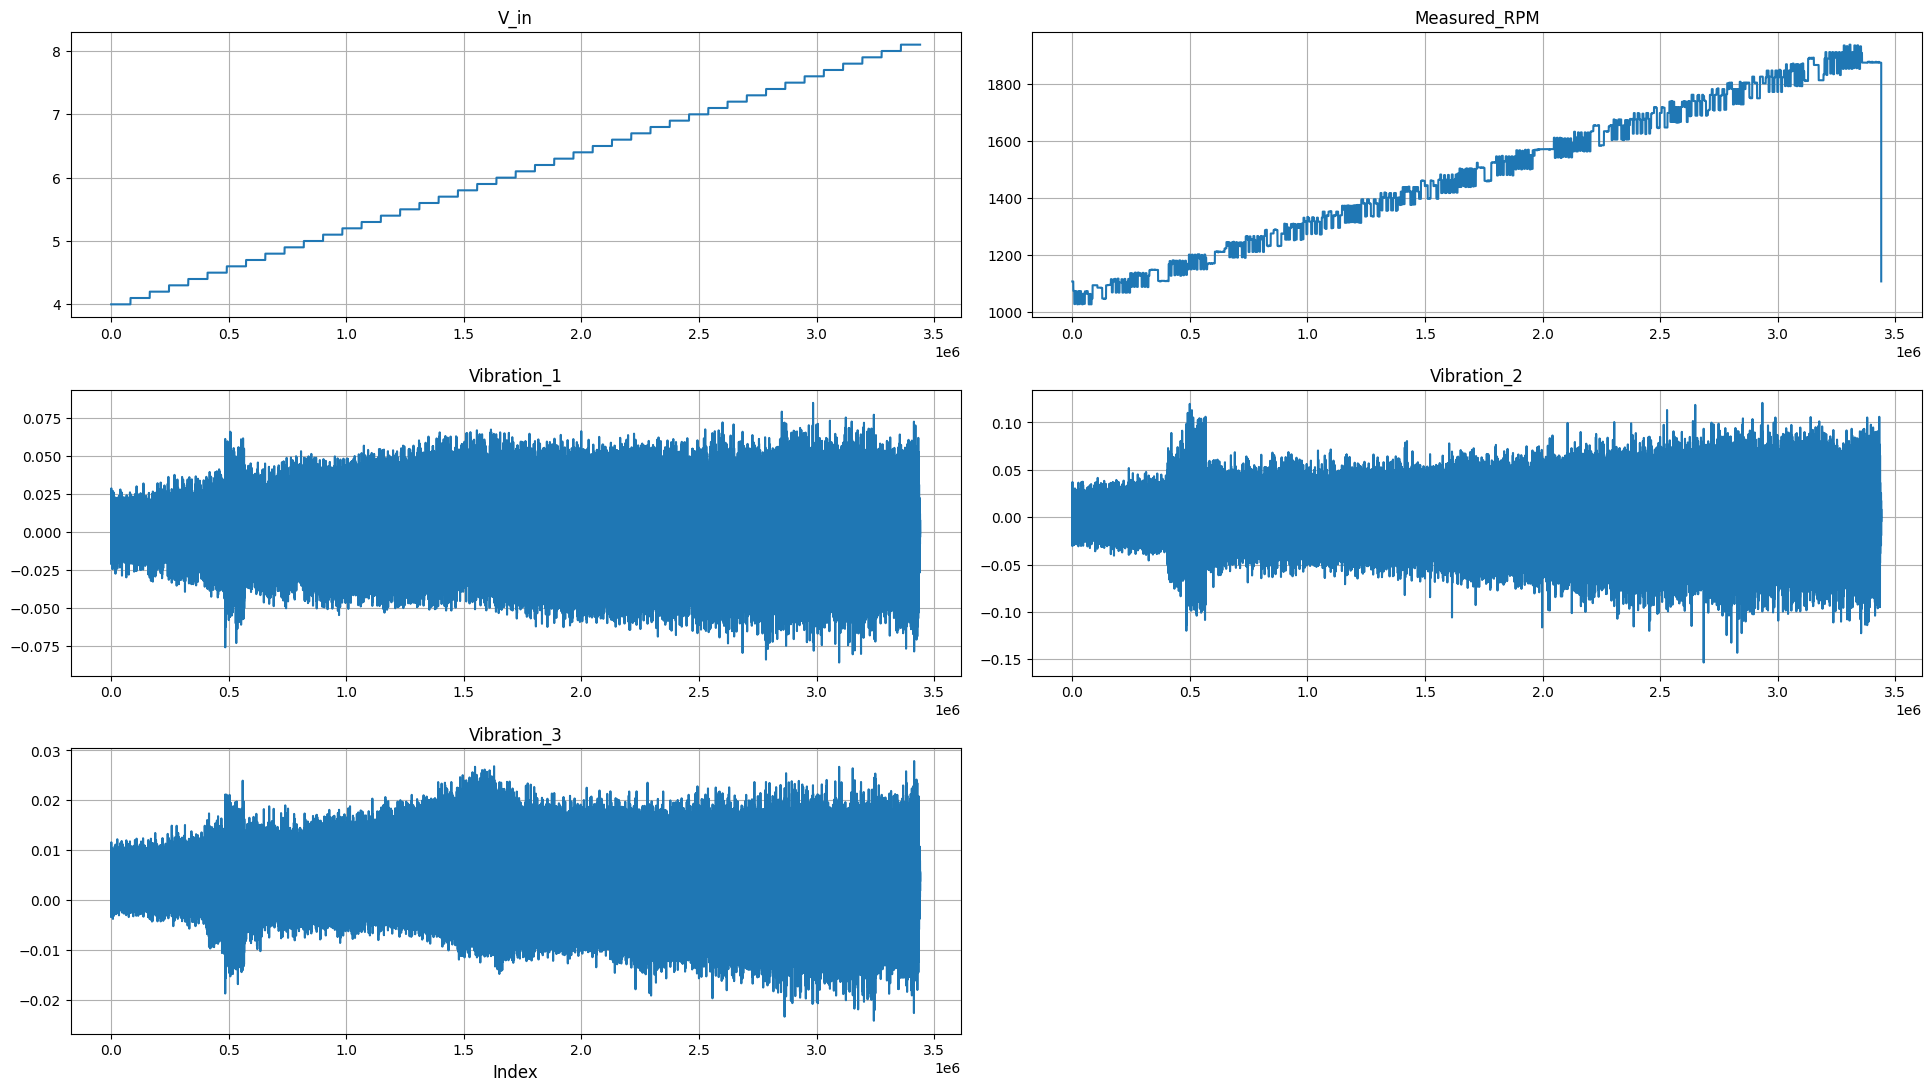

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\4E_0.csv


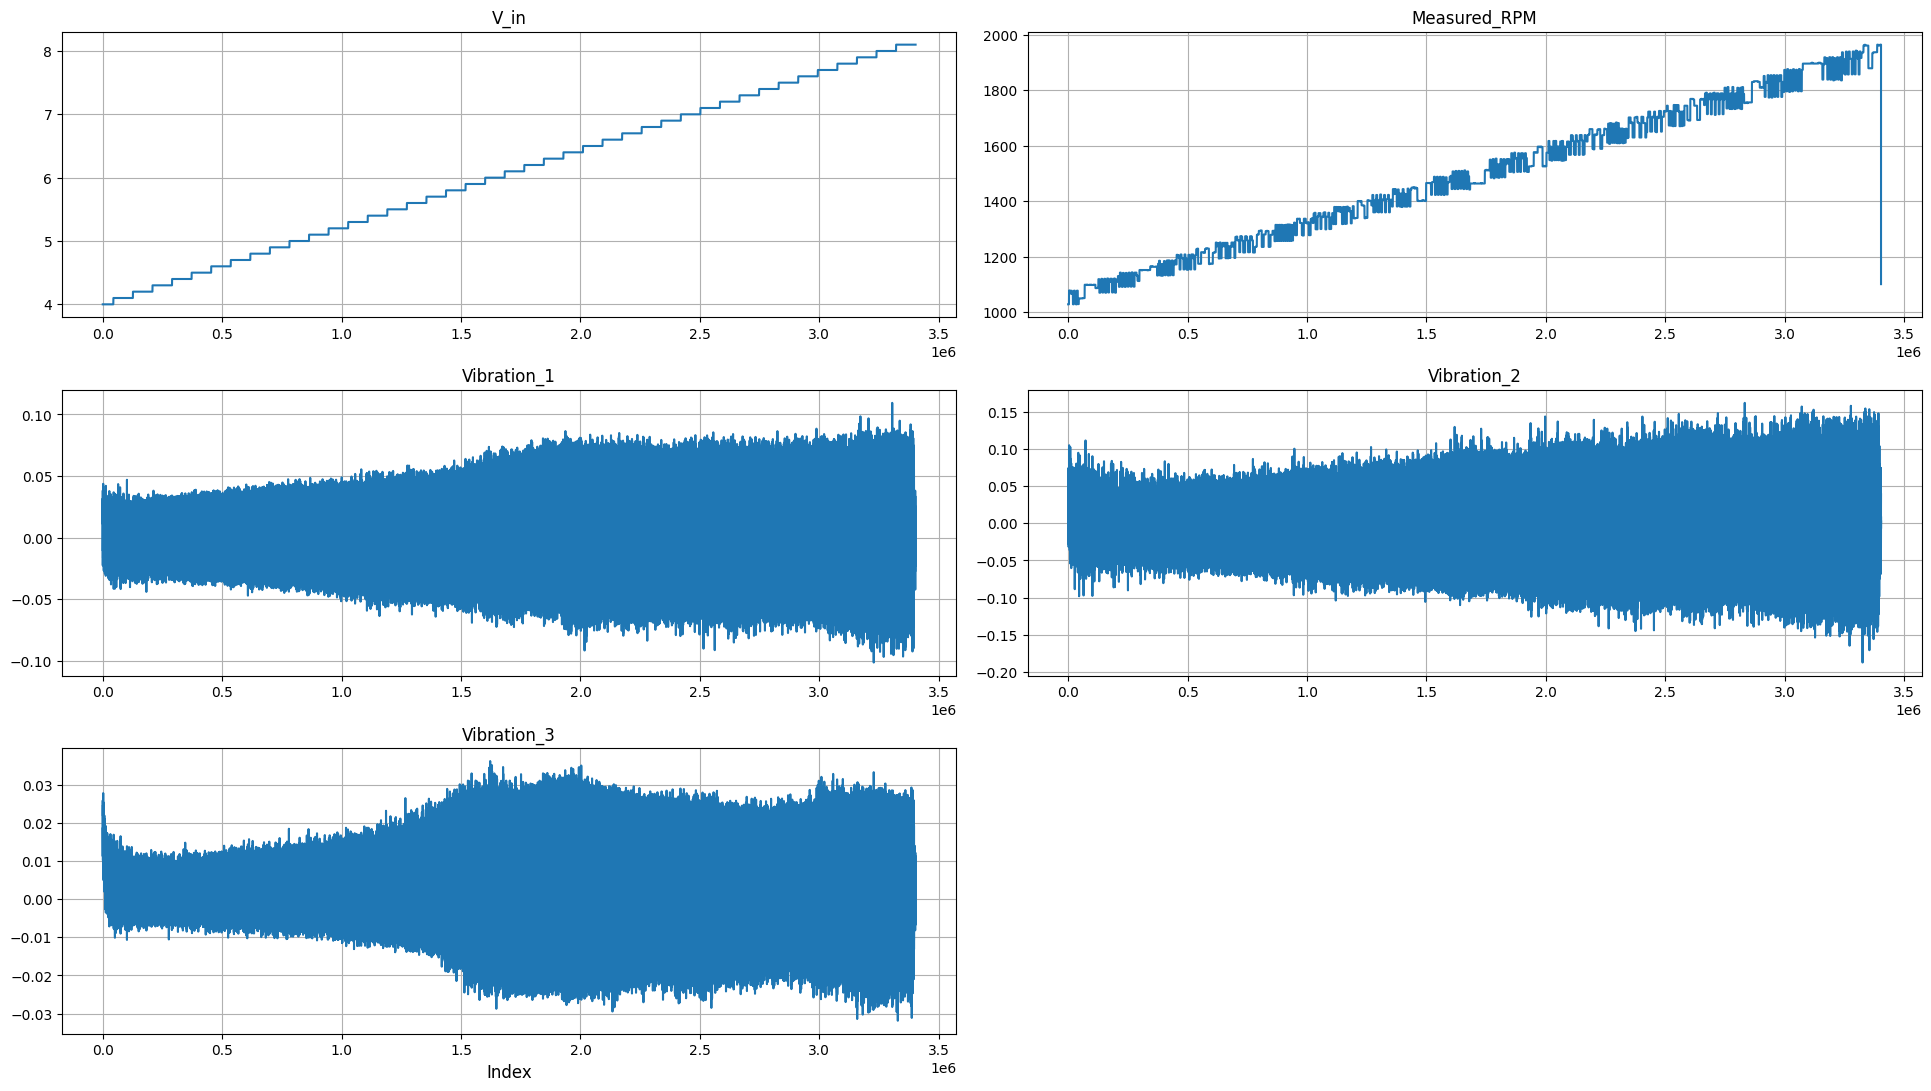

c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\data\raw\4E_1.csv


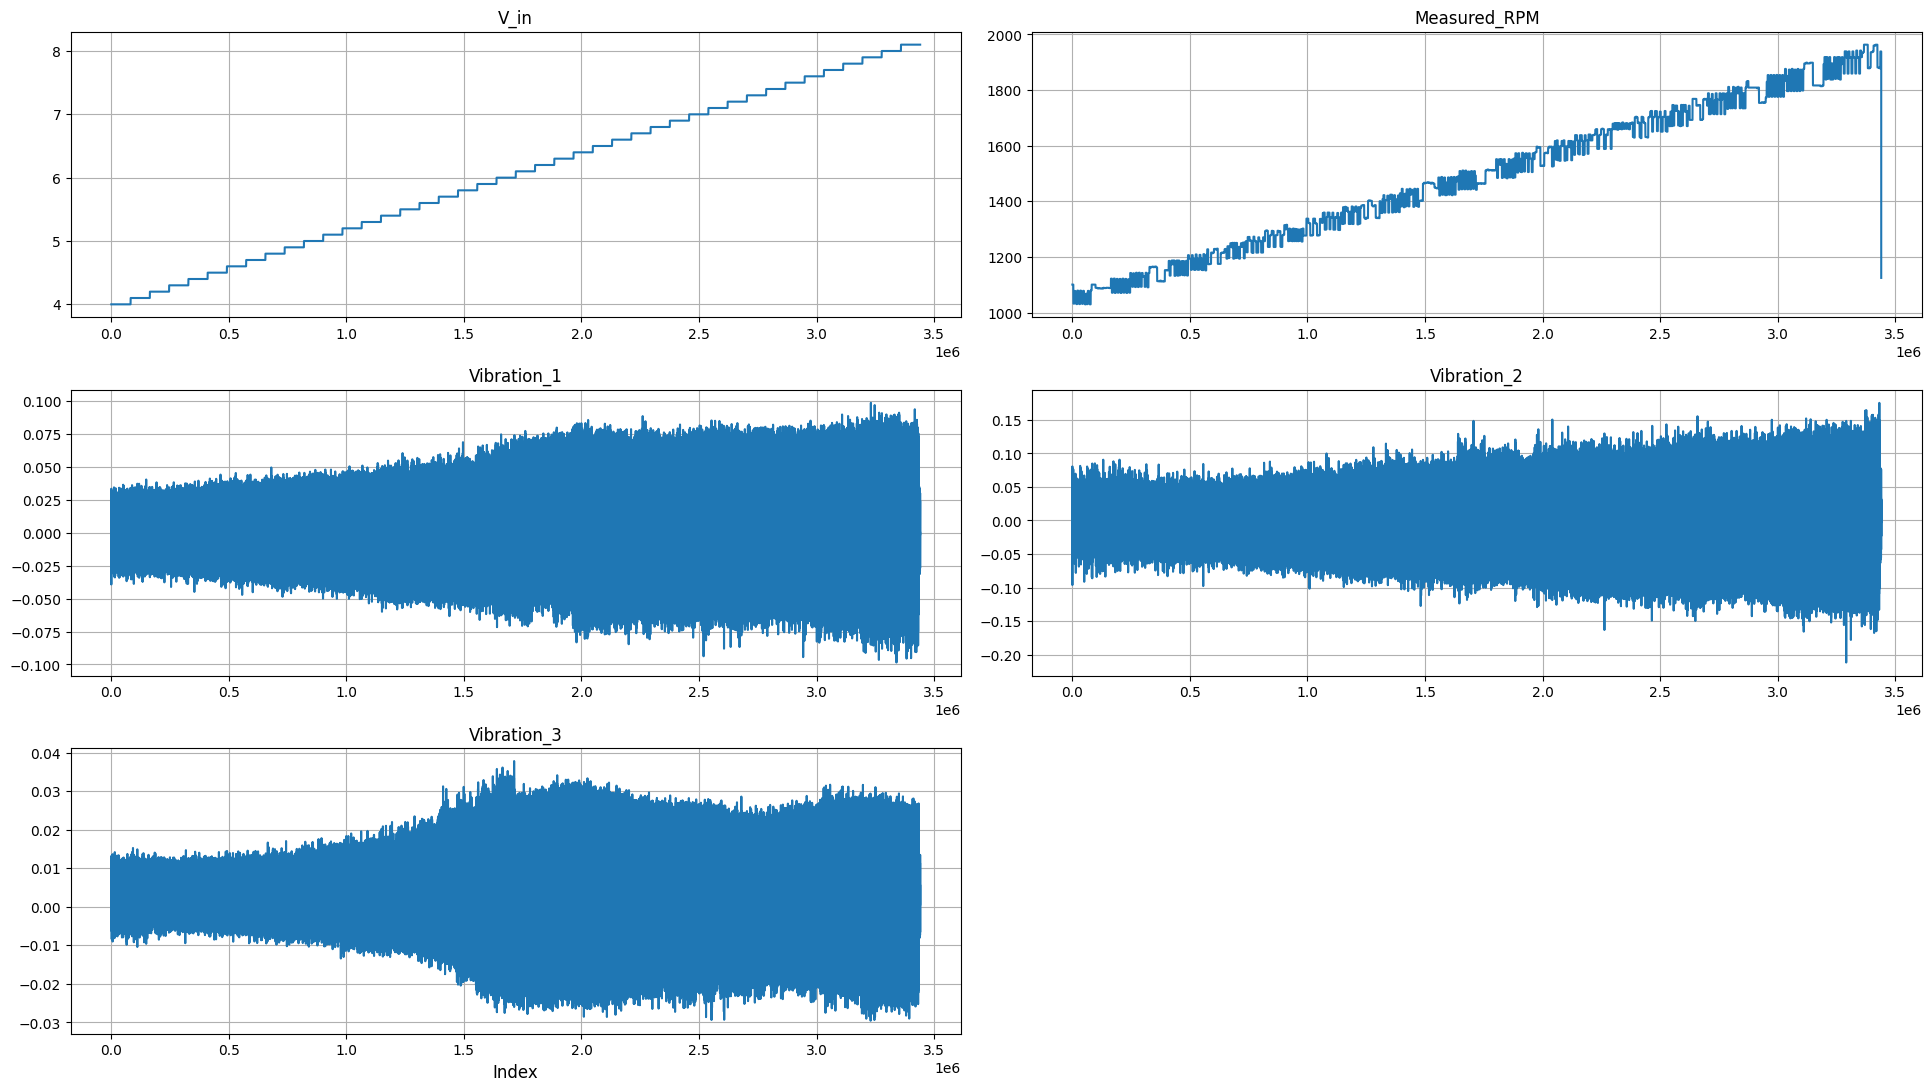

In [ ]:
if not TESTING:

    # visualize one random dataset for data validation
    # vis.plot_columns_as_subplots(measurement_cycles[CONTROL_INDEX],
    #                              measurement_cycles[CONTROL_INDEX].columns)
    for dataset in measurement_cycles:
        print(dataset.attrs["path"])
        vis.plot_columns_as_subplots(dataset,
                                     dataset.columns)

    
else:
    for dataset in test_measurement_cycles:
        # visualize the program testing set
        print(dataset.attrs["path"])
        vis.plot_columns_as_subplots(dataset, dataset.columns)

##### **Fast Fourier Transformation**
Eine Fast Fourier Transformation (FFT) über führt die Daten eines ausgewählten Sensors vom Zeit- in den Frequenzbereich. Sie verwendet ein Fenster von einer Sekunde bzw. $n=4096$ Messwerten. Mey et al. verwenden in ihrer Arbeit die ersten 2048 Fourier-Koeffizienten. Diese sind der *Zero Frequency Term* bei $0 \times f_s$, die Summe des Signals, und die 2048 positiven Frequenzanteile (*frequency components*). NumPy bietet zur Berechnung der positiven Frequenzanteile die *Real FFT* numpy.rfft(), die in diesem Projekt implementiert ist. Pro Sekunde des ursprünglichen Datensatzes generiert die FFT somit 2048 Frequenzanteile. Aufgrund der Halbierung der Anzahl von Messwerten, speichert ein neues Dataset die Fourier-Koeffizienten. 

$$A_k = \frac{1}{n} \cdot \sum^{n-1}_{m=0} a_m \cdot e^{-2\,\pi\,i\,\frac{m\,k}{n}} \qquad \text{mit} \qquad a_m = e^{2\,\pi\,i\,m\,f\,\Delta t} \quad \text{und} \quad k = 0,~\dots,~n-1$$

Für eine spätere Zuordnung wird mit derselben Fenstergröße der Median der Drehzahlen berechnet. Das Label des ursprünglichen Datensatzes wird in das neue Dataset übertragen.

In [ ]:
SENSOR: int = 1

if not TESTING:

    for index, dataset in enumerate(measurement_cycles):
        # calculate fft frequencies and magnitudes alongside the median rpms
        fft_dataset = pre.calculate_fft_magnitudes(dataset, column=f"Vibration_{SENSOR}", normalize=False)
        rpms = pre.median(dataset, column="Measured_RPM", stretch=True)
        fft_dataset["rpm"] = rpms[::2]
        measurement_cycles[index] = fft_dataset

else:
    
    for index, dataset in enumerate(test_measurement_cycles):
        fft_data = pre.calculate_fft_magnitudes(dataset, column=f"Vibration_{SENSOR}", normalize=False)
        rpms = pre.median(dataset, column="Measured_RPM", stretch=True)
        fft_data["rpm"] = rpms[::2]
        test_measurement_cycles[index] = fft_data

fft_frequency  fft_magnitude           rpm
count   6.574080e+06   6.574080e+06  6.574080e+06
mean    1.024500e+03   3.452149e-01  1.477395e+03
std     5.912067e+02   5.797520e-01  4.911522e+02
min     1.000000e+00   5.961574e-06  6.175284e+02
25%     5.127500e+02   3.571652e-02  1.048660e+03
50%     1.024500e+03   1.263290e-01  1.474597e+03
75%     1.536250e+03   4.031372e-01  1.896559e+03
max     2.048000e+03   1.772706e+01  2.363895e+03

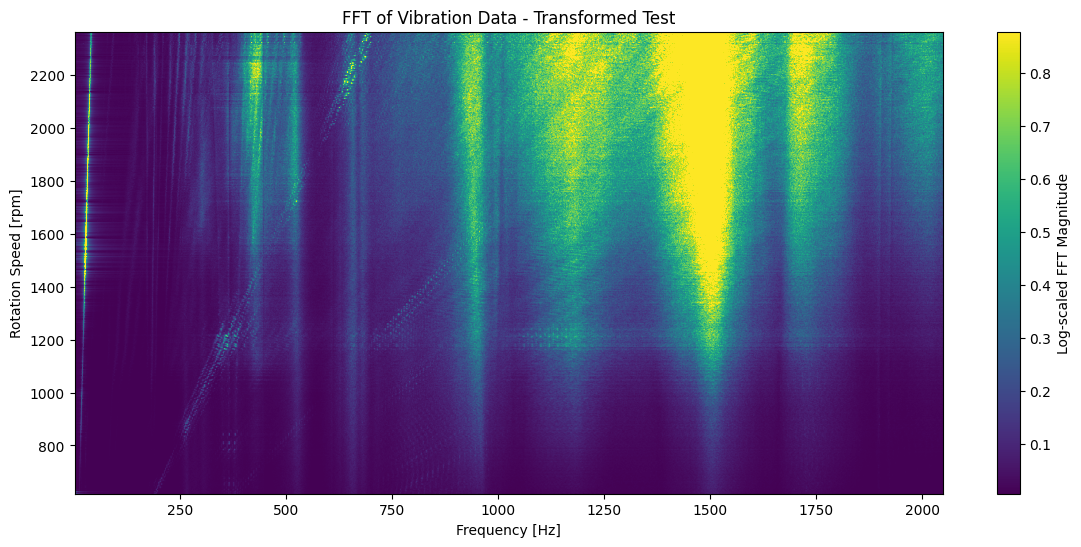

In [ ]:
if not TESTING:

    # describe one random dataset for data validation
    display(measurement_cycles[CONTROL_INDEX].describe())
    vis.plot_fft_spectrogram(data_frame=measurement_cycles[CONTROL_INDEX],
                                 figsize=(14, 6))

else:
    
    # program testing set
    for dataset in test_measurement_cycles:
        display(dataset.describe())
        vis.plot_fft_spectrogram(data_frame=dataset,
                                 figsize=(14, 6))

##### **Robust Scaling**

Robust Scaling entfernt aus der Messreihe $X$ 

Interquantilabstand (*Inter-Quantile Range*, IRQ) zwischen dem 5%-Quantil $x_{0.05}$ und dem 95%-Quantil $x_{0.95}$.

$$x^*_i = \frac{x_i - \text{median}~{X}}{x_{0.95} - x_{0.05}} \qquad \text{mit} \qquad X=\{x_0,~x_1,~\dots,~x_n-1\}$$

In [ ]:
if not TESTING:

    for index, dataset in enumerate(measurement_cycles):
        measurement_cycles[index] = pre.scale_robust(dataset, column="fft_magnitude")

else:
    for index, dataset in enumerate(test_measurement_cycles):
        scaled_data = pre.scale_robust(dataset, column="fft_magnitude")
        test_measurement_cycles[index] = scaled_data

fft_frequency  fft_magnitude           rpm
count   6.574080e+06   6.574080e+06  6.574080e+06
mean    1.024500e+03   1.220748e-01  1.477395e+03
std     5.912067e+02   3.831211e-01  4.911522e+02
min     1.000000e+00  -2.668019e-01  6.175284e+02
25%     5.127500e+02  -1.137762e-01  1.048660e+03
50%     1.024500e+03   0.000000e+00  1.474597e+03
75%     1.536250e+03   2.154995e-01  1.896559e+03
max     2.048000e+03   5.745490e+01  2.363895e+03

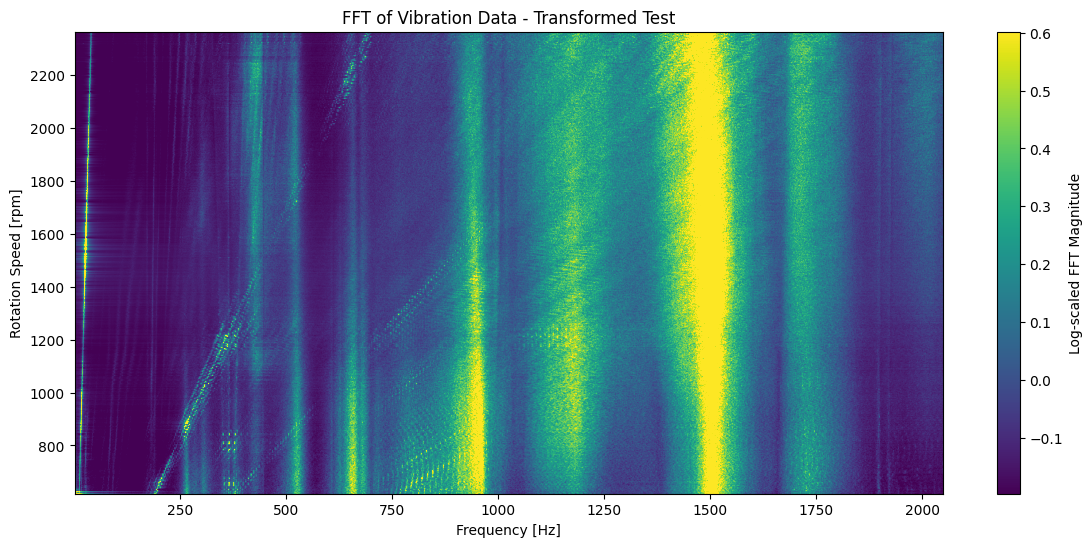

In [ ]:
if not TESTING:

    # describe one random dataset for data validation
    display(measurement_cycles[CONTROL_INDEX].describe())
    vis.plot_fft_spectrogram(data_frame=measurement_cycles[CONTROL_INDEX],
                                 figsize=(14, 6))

else:
    
    # program testing set
    for dataset in test_measurement_cycles:
        display(dataset.describe())
        vis.plot_fft_spectrogram(data_frame=dataset,
                                 figsize=(14, 6))

In [ ]:
# saving the preprocessed data
if not TESTING:

    for dataset in measurement_cycles:
        dl.save_dataset(dataset, uuid=UUID)

else:
    for dataset in test_measurement_cycles:
        dl.save_dataset(dataset, uuid=UUID)


0D_0_fft.csv successfully saved.
0D_1_fft.csv successfully saved.
1D_0_fft.csv successfully saved.
1D_1_fft.csv successfully saved.
2D_0_fft.csv successfully saved.
2D_1_fft.csv successfully saved.
3D_0_fft.csv successfully saved.
3D_1_fft.csv successfully saved.
4D_0_fft.csv successfully saved.
4D_1_fft.csv successfully saved.
0E_0_fft.csv successfully saved.
0E_1_fft.csv successfully saved.
1E_0_fft.csv successfully saved.
1E_1_fft.csv successfully saved.
2E_0_fft.csv successfully saved.
2E_1_fft.csv successfully saved.
3E_0_fft.csv successfully saved.
3E_1_fft.csv successfully saved.
4E_0_fft.csv successfully saved.
4E_1_fft.csv successfully saved.
